# Neural Signal Compression for Brain Computer Interfaces

Neuralink, US Patent No. 2023/0284982 A1, Filed 3/9/2022, Published 9/14/2023

Notebook written by Michael Zhou (mgz2112@columbia.edu)

## Background

- **Neural signal compression** is a technique used for **transmitting and processing neural data**
- Gathering/transmitting data as a whole wirelessly leads to **excess information overflow**, which **increases latency/delay** of signal transmission. 
- **Data compression** solves this problem by preventing overflow/latency issues, reduces size and space, improving overall system performance. 

## Goal

This notebook provides an implementation of the 4 neural signal compression algorithms described in US patent application number US 2023/0284982 by Neuralink, titled "Neural Signal Compression for Brain Computer Interfaces".

The 4 compression algorithms include:
- <font color='blue'>**Lossless** compression</font> 
- <font color='red'>**Lossy** compression</font> 
- <font color='green'>**Sparse** compression: **Binned-Spike** mode</font> 
- <font color='green'>**Sparse** compression: **Spike-Band** mode</font> 

In [1005]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm
import zlib
import struct
import pywt
import array
import fractions

## Neural Transmitter - Overall Signal Flowchart
![alt text](Flowchart.png)

## <font color='blue'> Lossless Compression </font> 

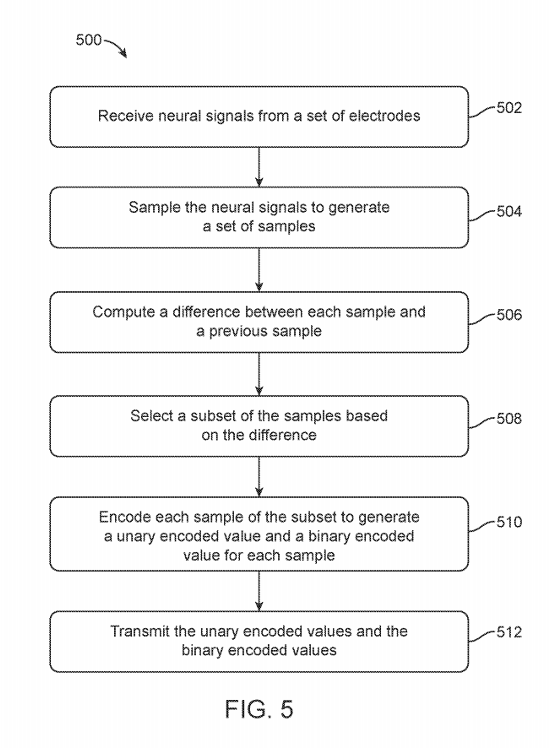

### 1. Receive Signal

Receive neural signals from electrodes. 

Since we do not have the actual equipment, let's generate a (simulated) neural signal. 

In [910]:
fs = 20000
T = 2

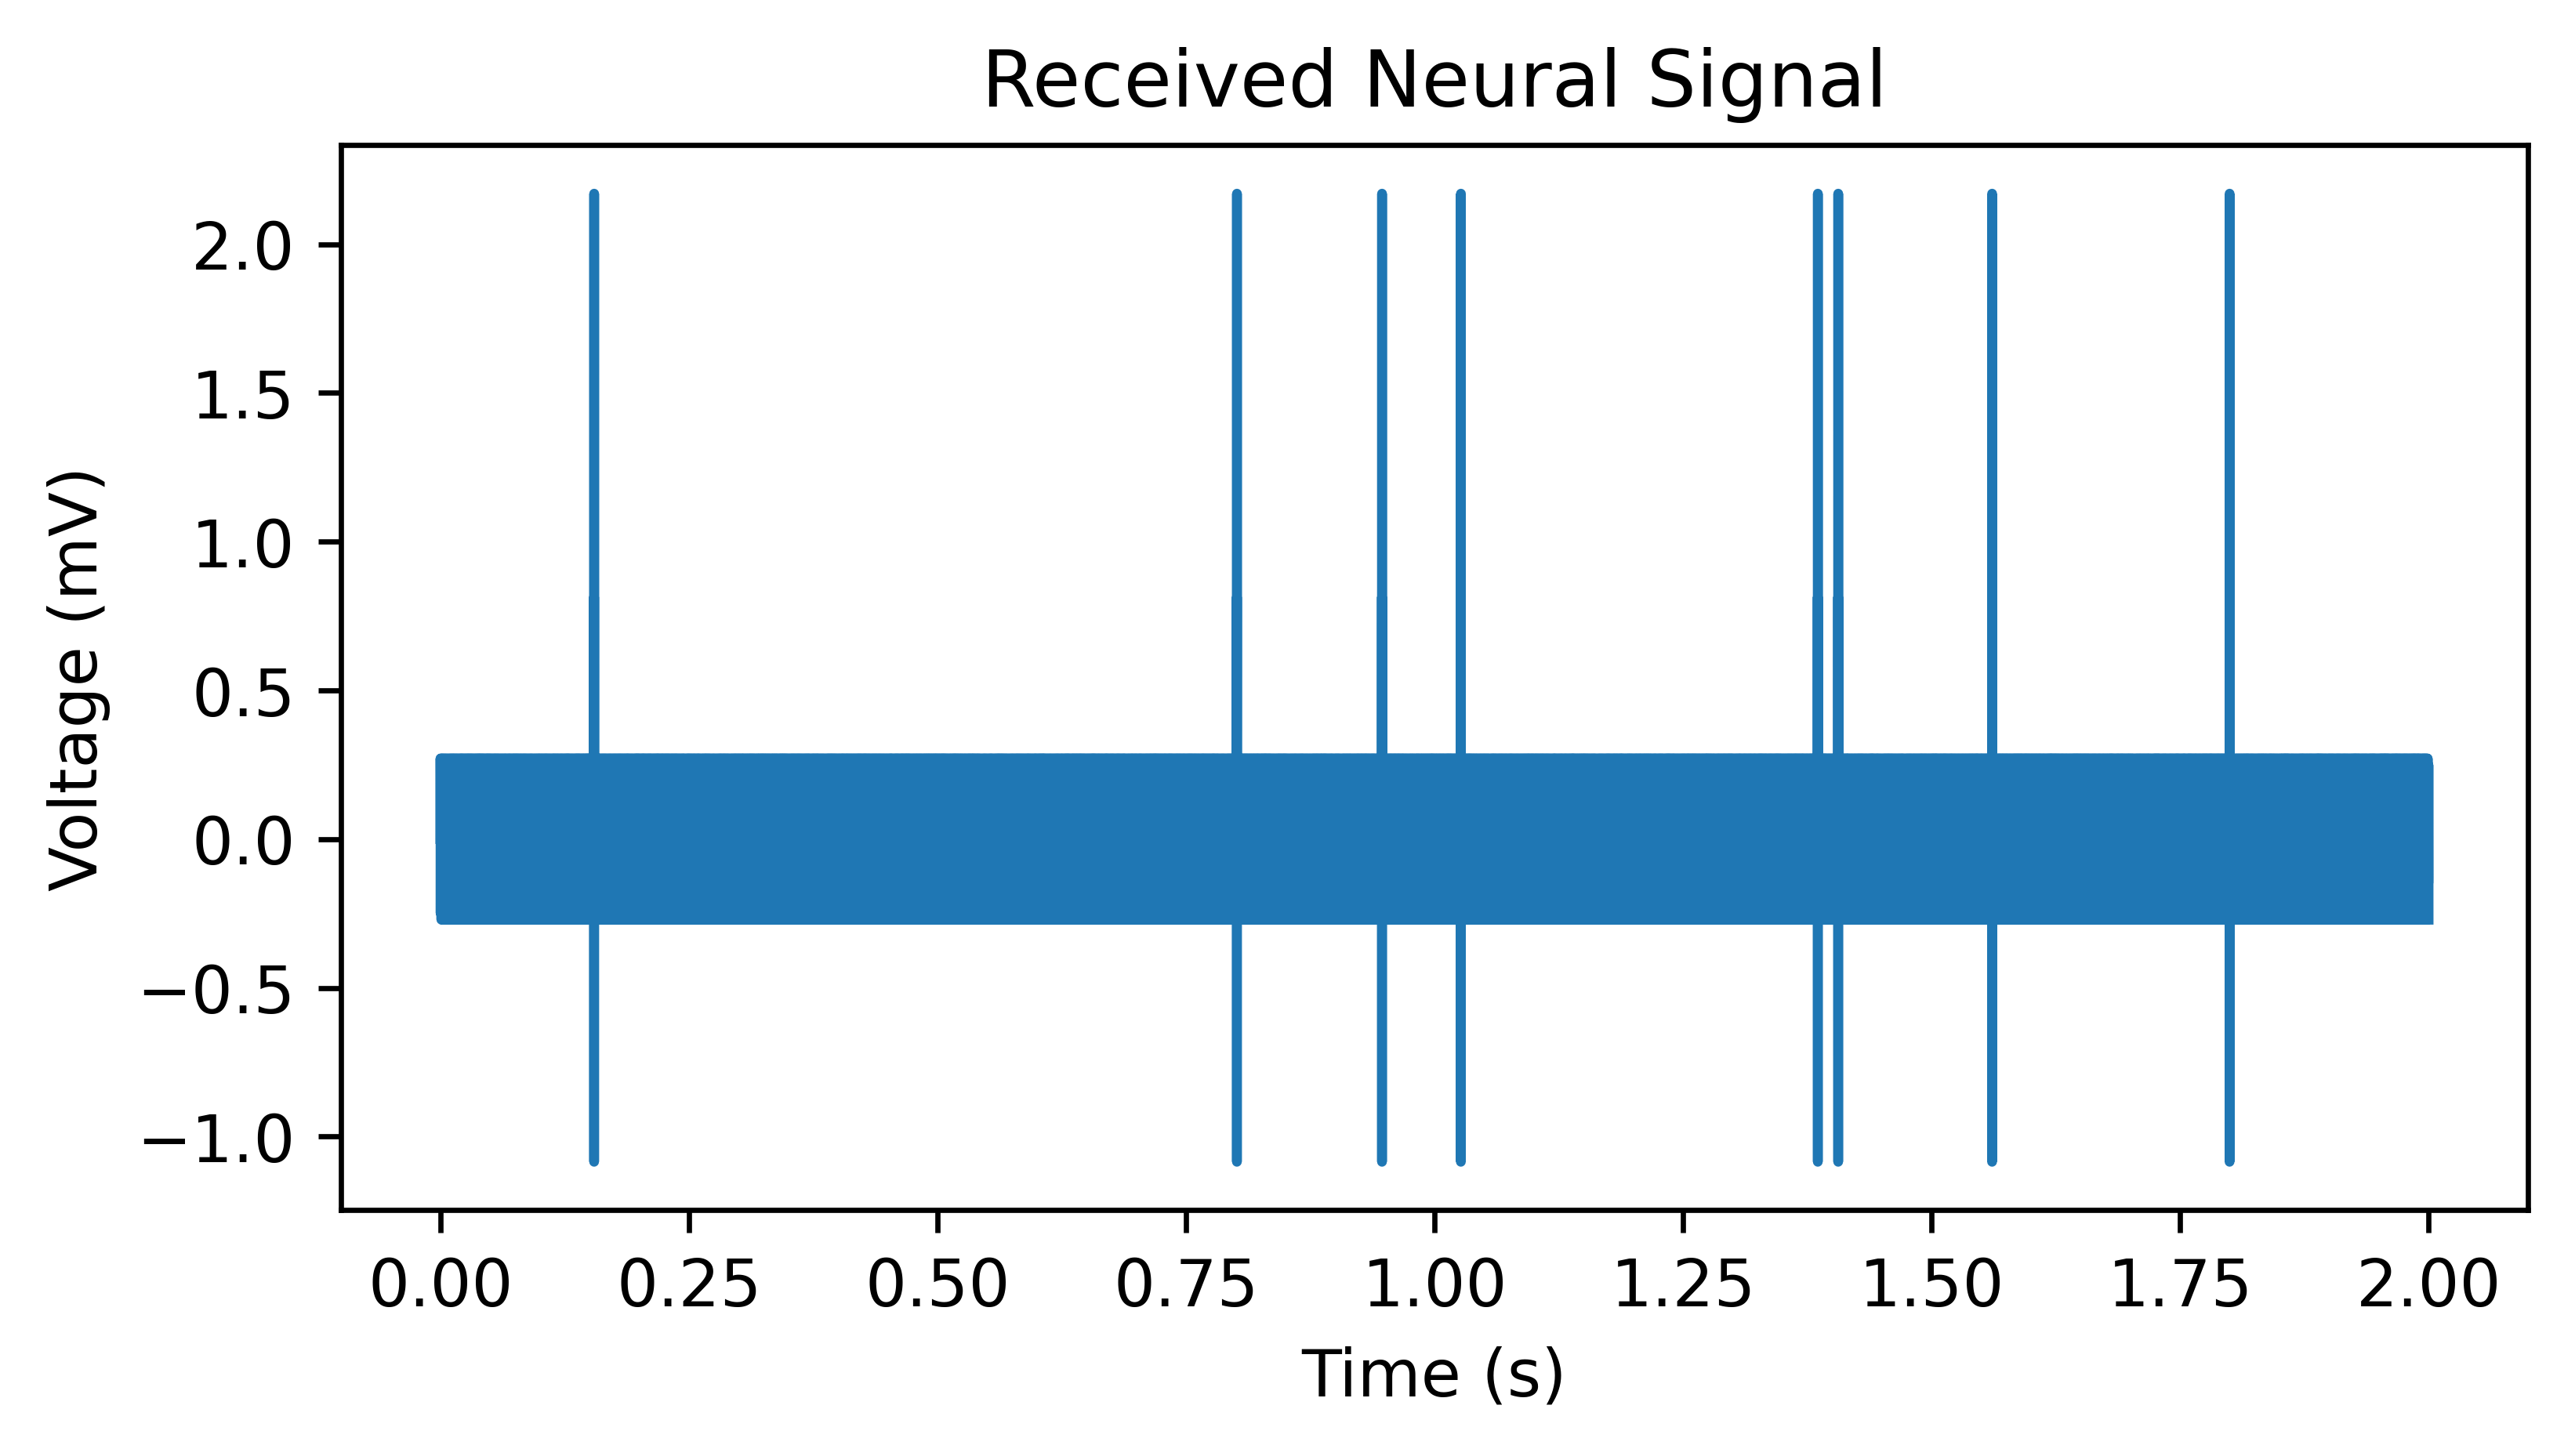

In [911]:
%run sampler.ipynb 

sampler = Sampler(fs, T, n_spikes=8)
t = sampler.t
x = sampler.sample()

### 2. Generate Set of Samples (that correspond to spikes)

Detect spikes in the signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

The patent mentions **two operation modes**: **broadband** and **spike-snippets**. To save computational resources and memory, let's use the **spike-snippets** mode (only take the samples that revolve around a spike). 

### Detect spikes:

In [912]:
blackout_period = 0.04

In [913]:
# Used for MAD + threshold calculations
alpha=0.0002
beta=3.75

In [914]:
# Set threshold values here
MAX_ASYM = 4
MIN_RATIO = 1.01
MAX_COST = 2
MIN_THRES = -0.004
MAX_THRES = 0.002
MAX_LDIST = 0.1
MIN_RDIST = 5e-5
MAX_RDIST = 0.1

<Figure size 432x288 with 0 Axes>

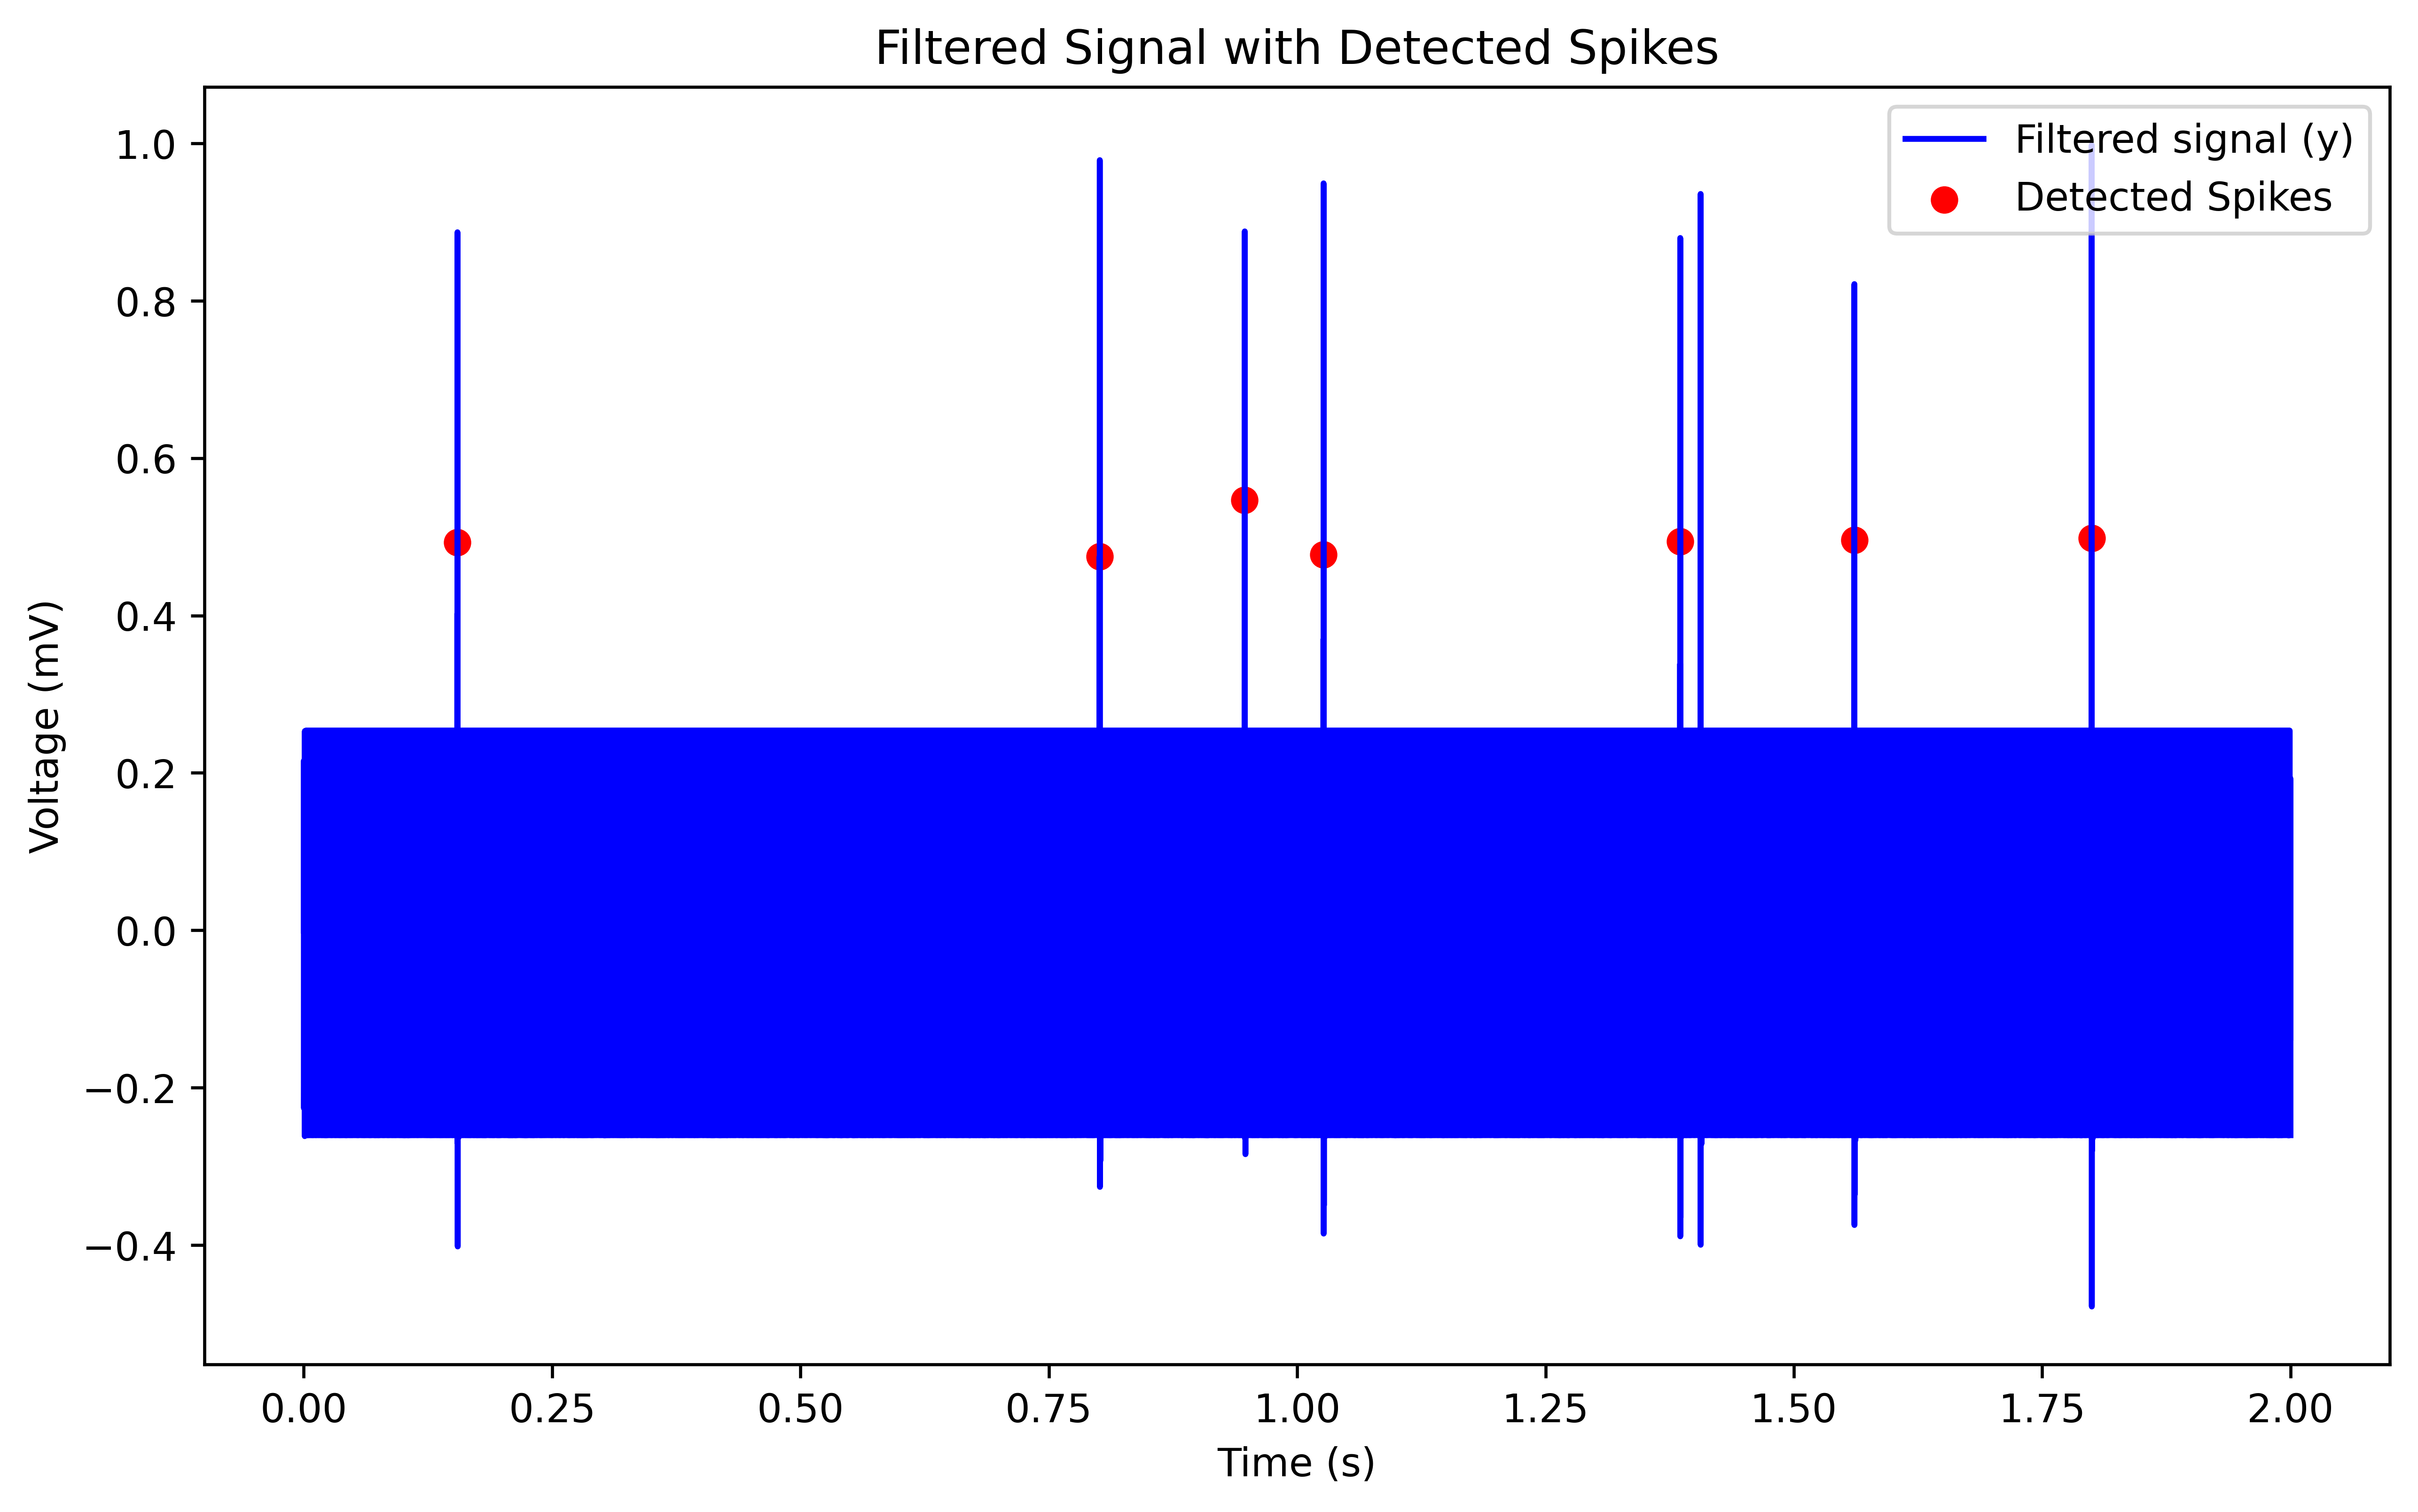

In [915]:
%run spike_detector.ipynb 

spike_detector = SpikeDetector(x, t, 
                               fs, 
                               blackout_period = blackout_period,
                               alpha = alpha,
                               beta = beta,
                               MIN_RATIO = MIN_RATIO,
                               MAX_ASYM = MAX_ASYM,
                               MAX_COST = MAX_COST,
                               MIN_THRES = MIN_THRES,
                               MAX_THRES = MAX_THRES,
                               MAX_LDIST = MAX_LDIST,
                               MIN_RDIST = MIN_RDIST,
                               MAX_RDIST = MAX_RDIST
                              )
spikes = spike_detector.detect()
spike_detector.plot_spikes(spikes)

### Spike-Snippet Mode: Take Snippets of Samples that Revolve around Spikes

In [916]:
x = spike_detector.x
t = spike_detector.t
spike_times = np.array([spike[1]['rp'] for spike in spikes])

In [917]:
# Converts time t (in seconds) to index in data
def time_to_index(t):
    return int(t * fs)

In [918]:
def get_signal_snippets(x, t, spike_times, window_size=5):
    """
    Get snippets of the original signal centered around spike_times with a specific window size
    
    params:
    - signal: original signal
    - spike_times: times of each spike
    - window_size: length of window from point center
    
    Return:
    - snippets: snippets of the original signal
    """
    # Convert detected spike times to indices
    f = np.vectorize(time_to_index)
    spike_indices = f(spike_times)
    
    # Return the snippets centered around the spike indices with intervals: [point - window_size, point + window_size]
    snippets = np.array([x[point - window_size : point + window_size] for point in spike_indices])
    snippet_times = np.array([t[point - window_size : point + window_size] for point in spike_indices])
    return snippets, snippet_times

snippets, snippet_times = get_signal_snippets(x, t, spike_times, window_size=5)

In [919]:
# Convert snippet times to indices
f = np.vectorize(time_to_index)
snippet_indices = f(snippet_times).ravel()

In [920]:
# Make a copy of x first
x_snippets = np.copy(x)

# For all signals that are not part of the spike-snippets, set its value to zero.
for i in range(len(t)):
    if i not in snippet_indices:
        x_snippets[i] = 0

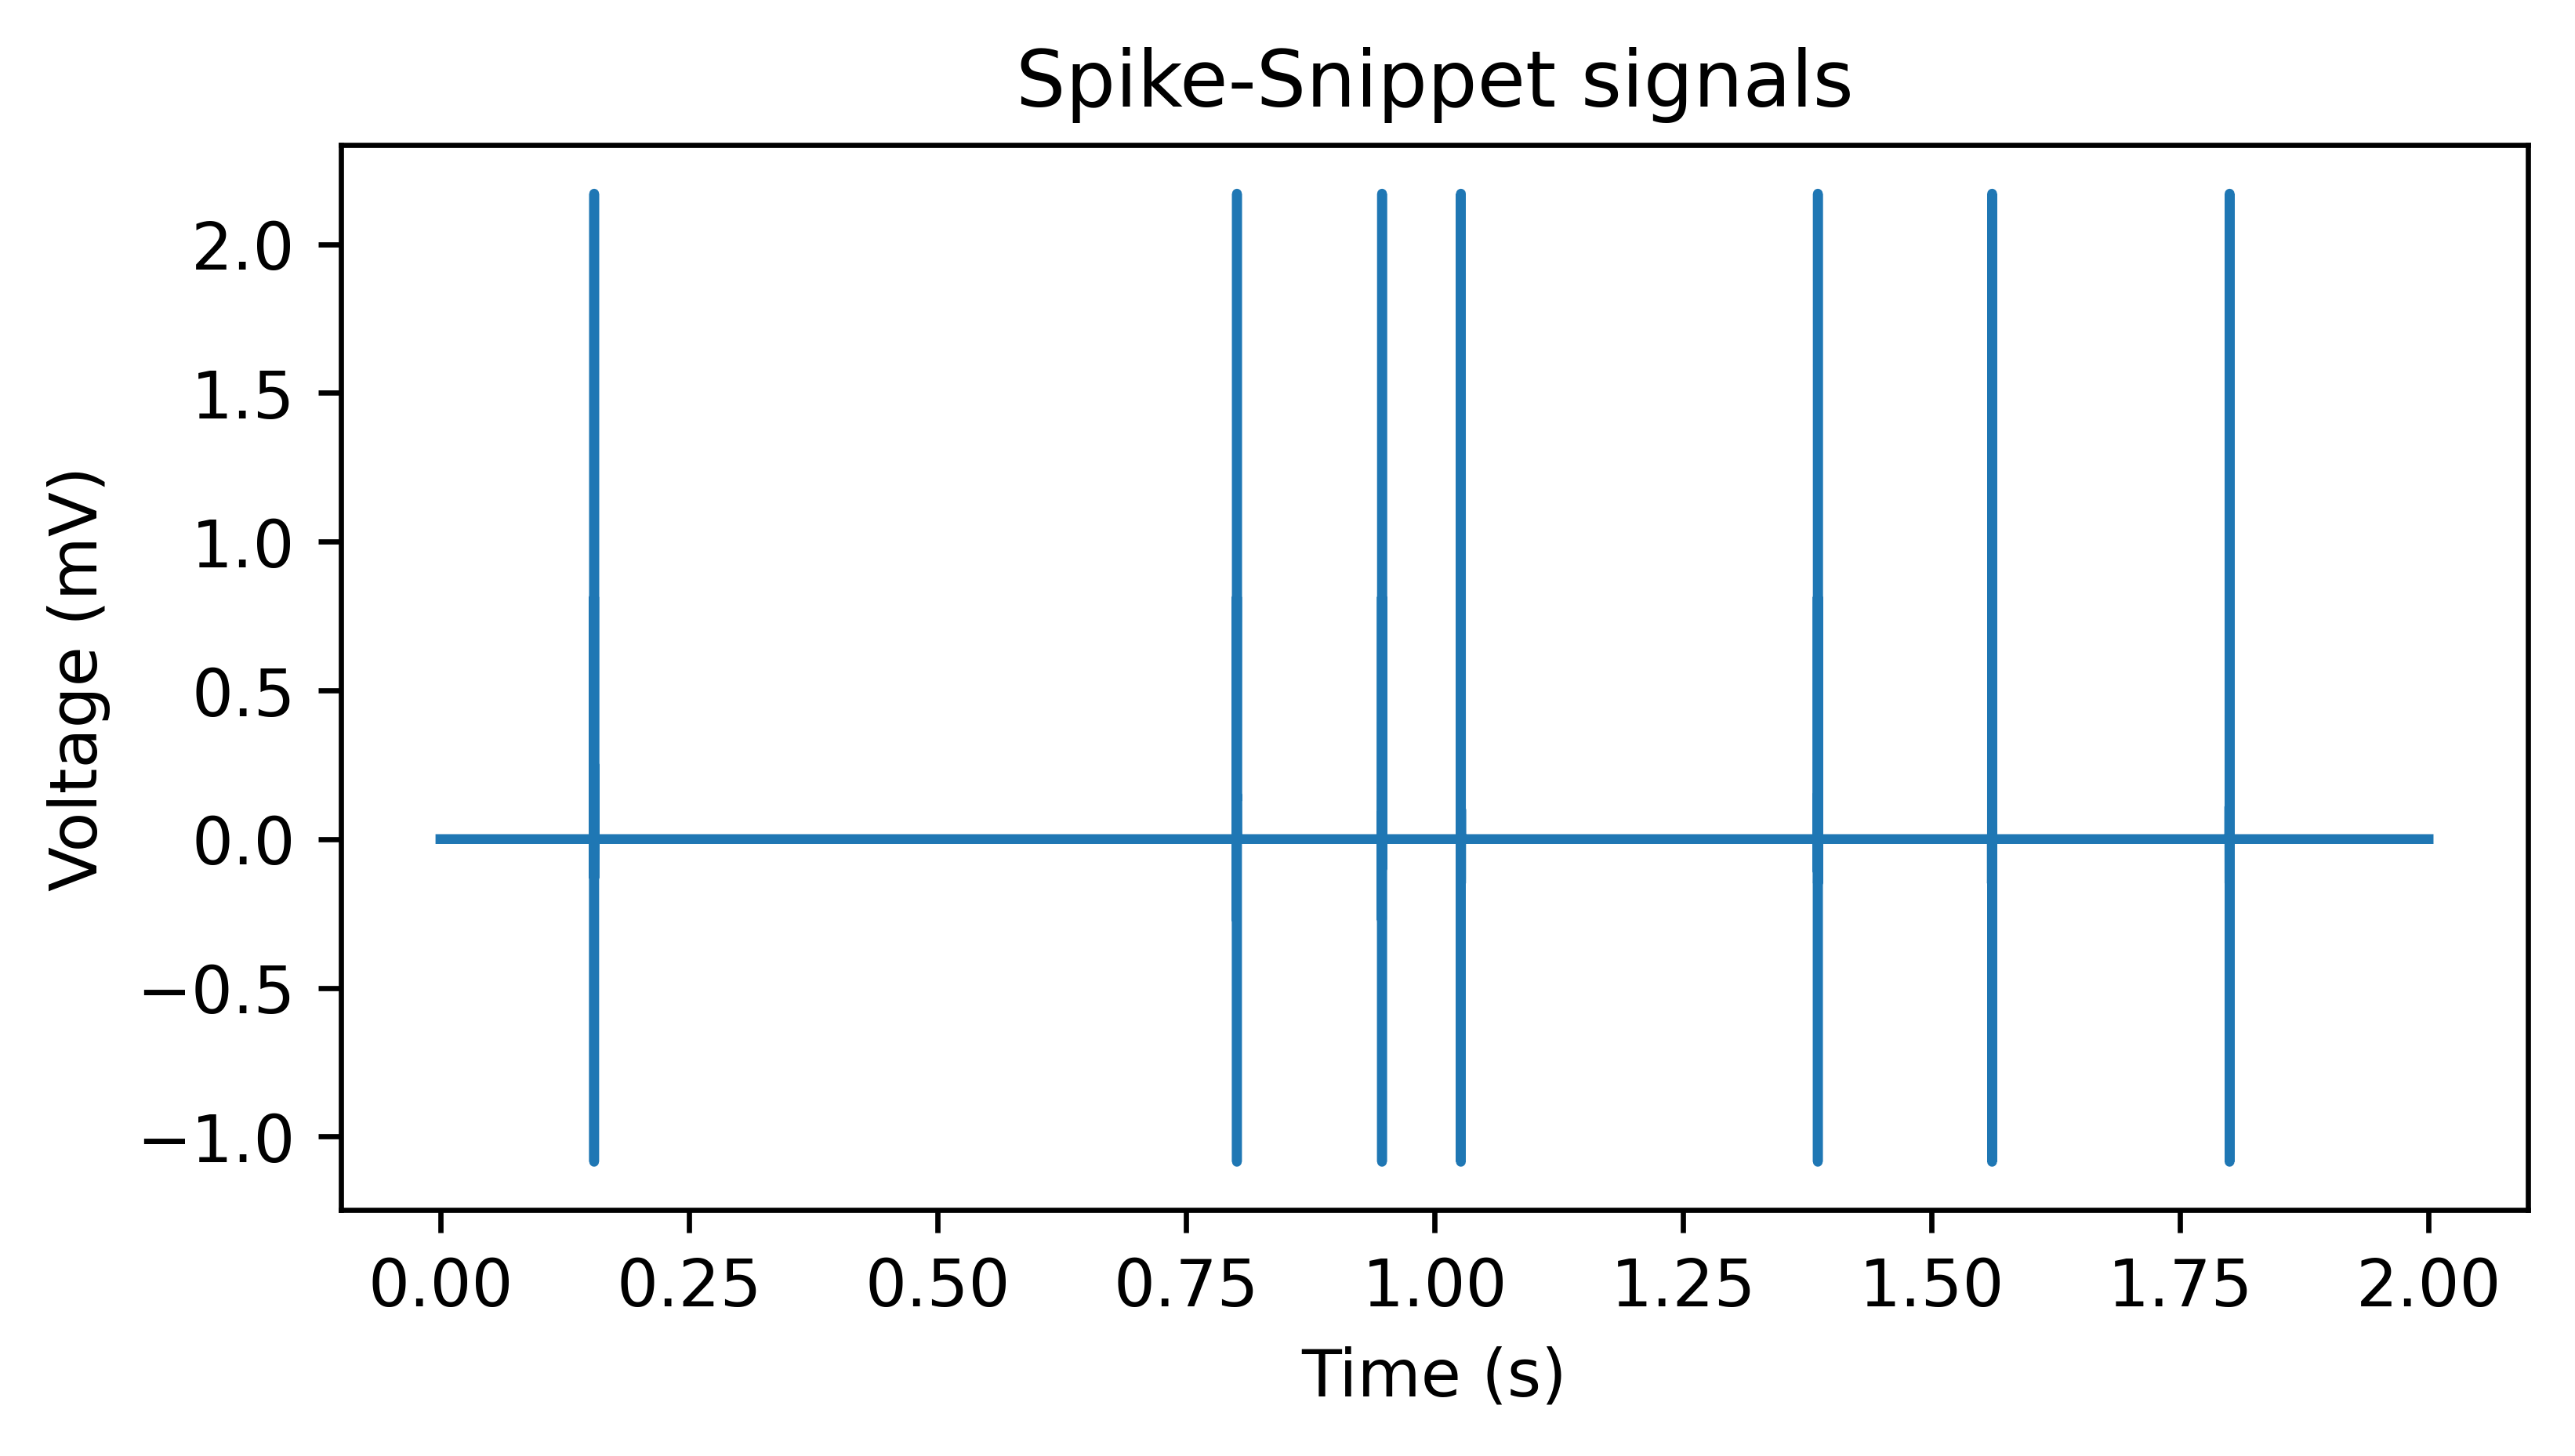

In [921]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

### 3. Compute Differences between Samples

The differences between samples can be represented as: 

$y[n] = x[n] - x[n - 1]$, 

where $n$ is the index of a signal, and $x$ is the original signal. 

In [922]:
# Compute differences between samples
diff = np.diff(x_snippets)

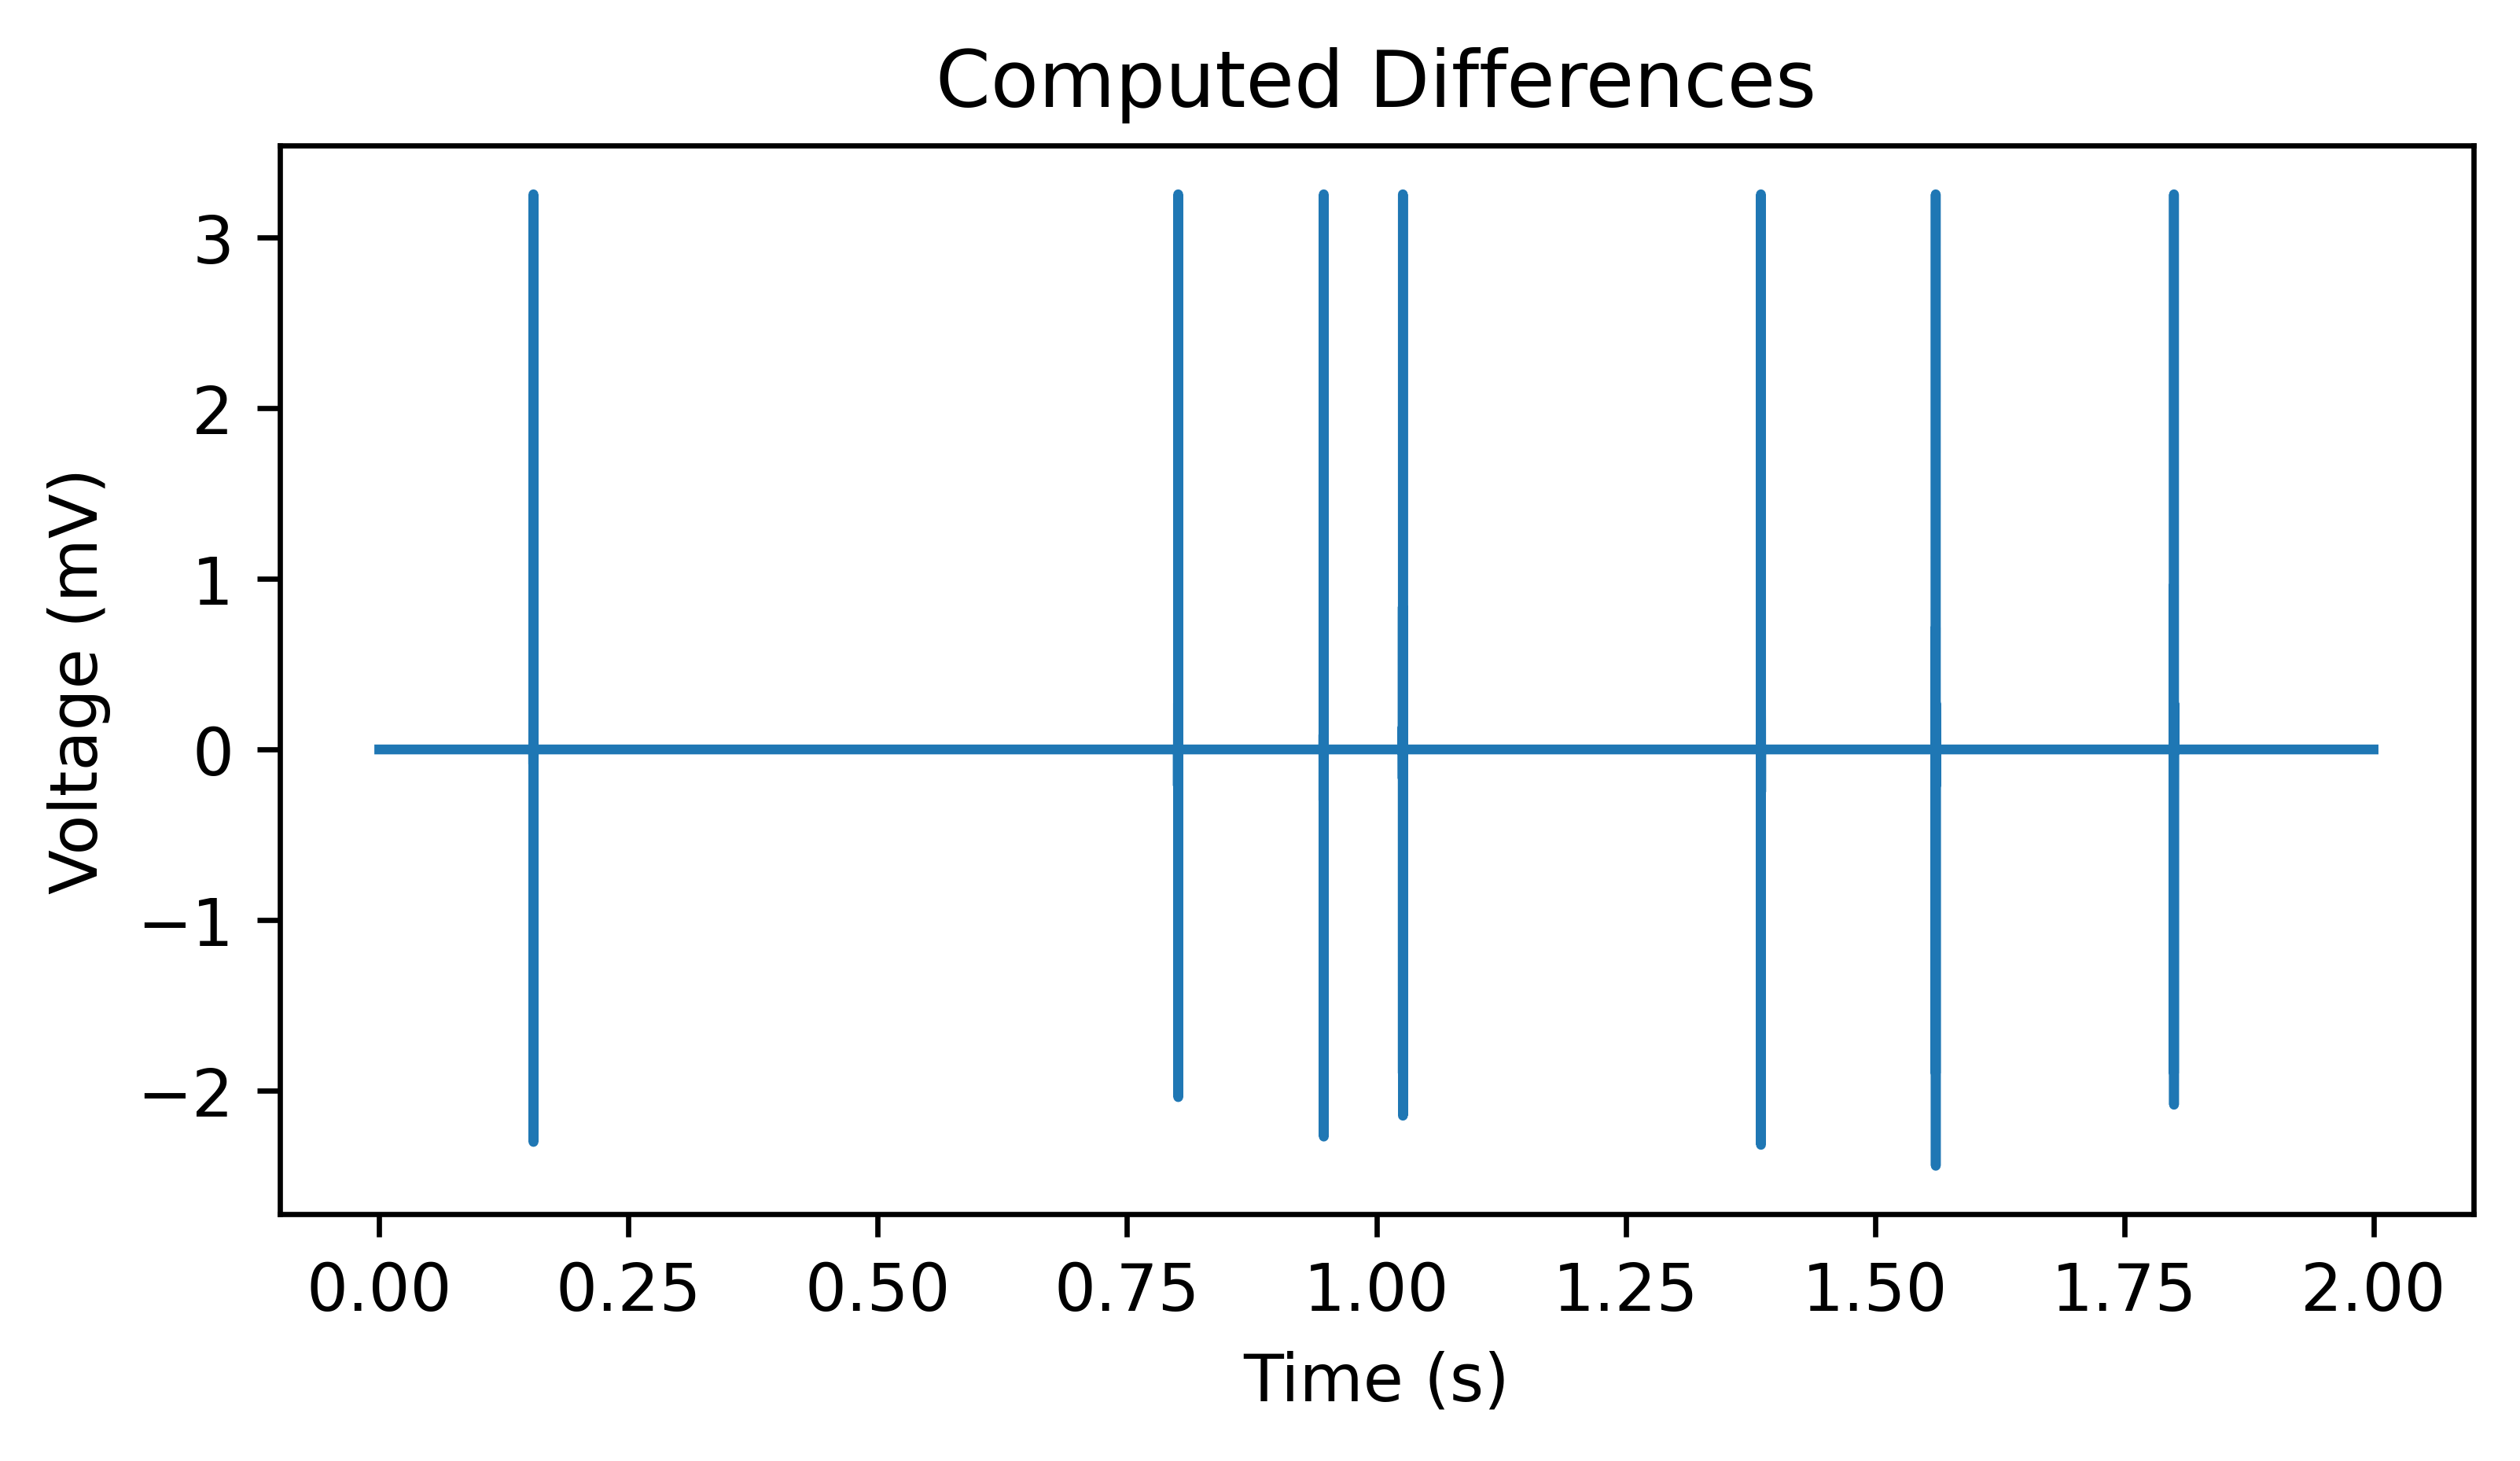

In [923]:
# Plot the computed differences
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Computed Differences")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t[1:], diff)
plt.show()

### 4. Identify Subset of Values (with Non-Zero Difference)

To reduce duplicative data, as well as the size per symbol, we only sample a ***subset*** of samples, specifically those that have **non-zero difference**. 

In [924]:
# Take the subset with non-zero differences
subset_indices = np.where(diff > 0)[0]
diff_subset = diff[subset_indices]
t_subset = t[subset_indices]
x_subset = x_snippets[subset_indices]

In [925]:
# Do not use scientific notation
np.set_printoptions(suppress=True)

In [926]:
print('Subset of values with non-zero difference:\n', x_subset)

Subset of values with non-zero difference:
 [-0.10924226  0.00007613 -1.08504565 -0.13140331  0.0999693  -0.27102567
 -0.0000941   0.21261819 -1.08504565  0.13139763  0.         -0.27116261
 -0.00005525  0.27117052 -1.08504565 -0.09999773  0.          0.13141341
 -0.02240094 -1.08504565 -0.14848003 -0.13151637  0.         -0.10927636
 -1.08504565 -0.14844556 -0.13133438  0.09995543 -0.14850757 -0.13139459
  0.09997226 -1.08504565 -0.27117265  0.00006646  0.         -0.14843403
 -1.08504565 -0.27117376 -0.00001694]


### 5. Generate Unary & Binary-Encoded Value (via Rice-Golomb Encoding)

Compute a **factor** (e.g., entropy measure of samples) that **minimizes total size** of each **encoded sample**. 

To achieve a **high-compression ratio** with **low computational cost** (**minimal space & power usage**), we choose **Rice-Golomb encoding** as our encoding method. 

**Rice-Golomb encoding**: 

Based on the computed factor, compute a **quotient ($Q$, unary)** and **remainder ($R$, binary)**

$S = Q \times M + R$

$Q = [\frac{X}{M}]$ (encoded by [**unary encoding**](https://en-academic.com/dic.nsf/enwiki/148876); i.e., Q '1's followed by a '0')

$R = X - QM$ (encoded via **truncated binary encoding**; i.e., encode remainder in binary using $M - 1$ bits)

$M$ - selected via **Bernoulli process** to **predict M** value (**minimum # of bits** to **encode**) to **minimize total size of encoded sample** (selected based on the **maximum value** to be encoded)

We know the $X$, the original signal, is given in **Q8.8** encoding (8 bits integer, 8 bits fraction)

In [927]:
def determine_optimal_m(max_value):
    # Find the optimal value for m based on the maximum value encountered in the data
    m = 1
    while 2 ** m < max_value:
        m += 1
    return m

def rice_golomb_encode(value, m):
    sign = 0 if value >= 0 else 1
    abs_value = abs(value)
    quotient = abs_value // m # q = int(x / m)
    remainder = abs_value % m # r = x - qm 
    unary_code = '1' * quotient + '0' 
    binary_code = format(remainder, '0{}b'.format(m-1))
    return str(sign) + unary_code + binary_code

In [928]:
# x is in Q8.8 format (8 bits integer, 8 bits fraction)
values = x_subset
int_bits = 8  # Integer part bits
frac_bits = 8  # Fractional part bits

# Find the maximum value in the data
max_value_q88 = max(abs(int(value * (2**frac_bits))) for value in values)

# Determine the optimal value for 'm'
m = determine_optimal_m(max_value_q88)

print("Optimal value for 'm':", m)

encoded_values = []

# Encode and decode the values using the dynamically determined 'm'
for value in values:
    value_q88 = int(value * (2**frac_bits))
    encoded_value = rice_golomb_encode(value_q88, m)
    encoded_values.append(encoded_value)

Optimal value for 'm': 9


### 6. Transmit Unary and Binary Values to Bitstream

In [929]:
bitstream = ''

for value in encoded_values:
    bitstream += value

bitstream

'11110000000000000000000111111111111111111111111111111100000011111110000001100110000001111111111100000011000000000000111111000000000111111111111111111111111111111100000011101110000001100000000000111111110000001100000000000011111110000001101111111111111111111111111111111000000111111000000111000000000001110000001101000000101111111111111111111111111111111100000011111111000000010111100000011000000000001111000000000111111111111111111111111111111100000011111111000000010111100000011001100000011111111000000010111100000011001100000011111111111111111111111111111111110000001111111111100000011000000000000000000000111110000000011111111111111111111111111111111000000111111111110000001100000000000'

### Additional: Decode Bitstream

In [930]:
def rice_golomb_decode(encoded_value, m):
    sign = int(encoded_value[0])
    unary_length = encoded_value[1:].index('0') + 2
    quotient = unary_length - 1
    binary_code = encoded_value[unary_length:unary_length+m-1]
    remainder = int(binary_code, 2)
    abs_value = quotient * m + remainder
    return abs_value if sign == 0 else -abs_value

In [931]:
index = 0
decoded_values = []

while index < len(bitstream):
    substr_end = index + bitstream[index+1:].index('0') + m + 1
    decoded_value_q88 = rice_golomb_decode(bitstream[index : substr_end], m)
    decoded_value = decoded_value_q88 / (2**frac_bits)
    decoded_values.append(decoded_value)
    index = substr_end

In [932]:
print('Subset of values with non-zero difference:\n', x_subset)
print('Decoded values:\n', decoded_values)

Subset of values with non-zero difference:
 [-0.10924226  0.00007613 -1.08504565 -0.13140331  0.0999693  -0.27102567
 -0.0000941   0.21261819 -1.08504565  0.13139763  0.         -0.27116261
 -0.00005525  0.27117052 -1.08504565 -0.09999773  0.          0.13141341
 -0.02240094 -1.08504565 -0.14848003 -0.13151637  0.         -0.10927636
 -1.08504565 -0.14844556 -0.13133438  0.09995543 -0.14850757 -0.13139459
  0.09997226 -1.08504565 -0.27117265  0.00006646  0.         -0.14843403
 -1.08504565 -0.27117376 -0.00001694]
Decoded values:
 [-0.140625, 0.03515625, -1.1171875, -0.1640625, 0.1328125, -0.3046875, 0.03515625, 0.24609375, -1.1171875, 0.1640625, 0.03515625, -0.3046875, 0.03515625, 0.3046875, -1.1171875, -0.1328125, 0.03515625, 0.1640625, -0.0546875, -1.1171875, -0.18359375, -0.1640625, 0.03515625, -0.140625, -1.1171875, -0.18359375, -0.1640625, 0.1328125, -0.18359375, -0.1640625, 0.1328125, -1.1171875, -0.3046875, 0.03515625, 0.03515625, -0.1796875, -1.1171875, -0.3046875, 0.03515625]

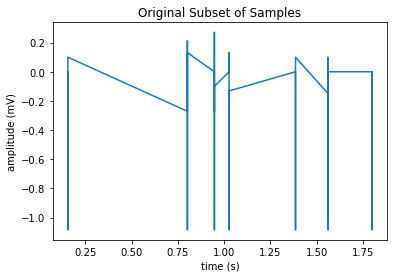

In [933]:
# Plot original subset of samples
plt.title("Original Subset of Samples")
plt.plot(t[subset_indices], x_subset)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

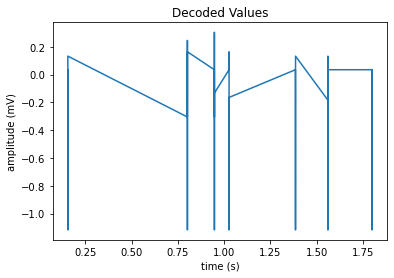

In [934]:
# Plot decoded values (from the Rice-Golomb encoded values)
plt.title("Decoded Values")
plt.plot(t[subset_indices], decoded_values)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

You can see here that the decoded values and the original subset of samples (ground truth) are very similar in plot shape, as their values scale similarly. That means our encoding/decoding works properly. 

## <font color='red'>Lossy Compression</font>

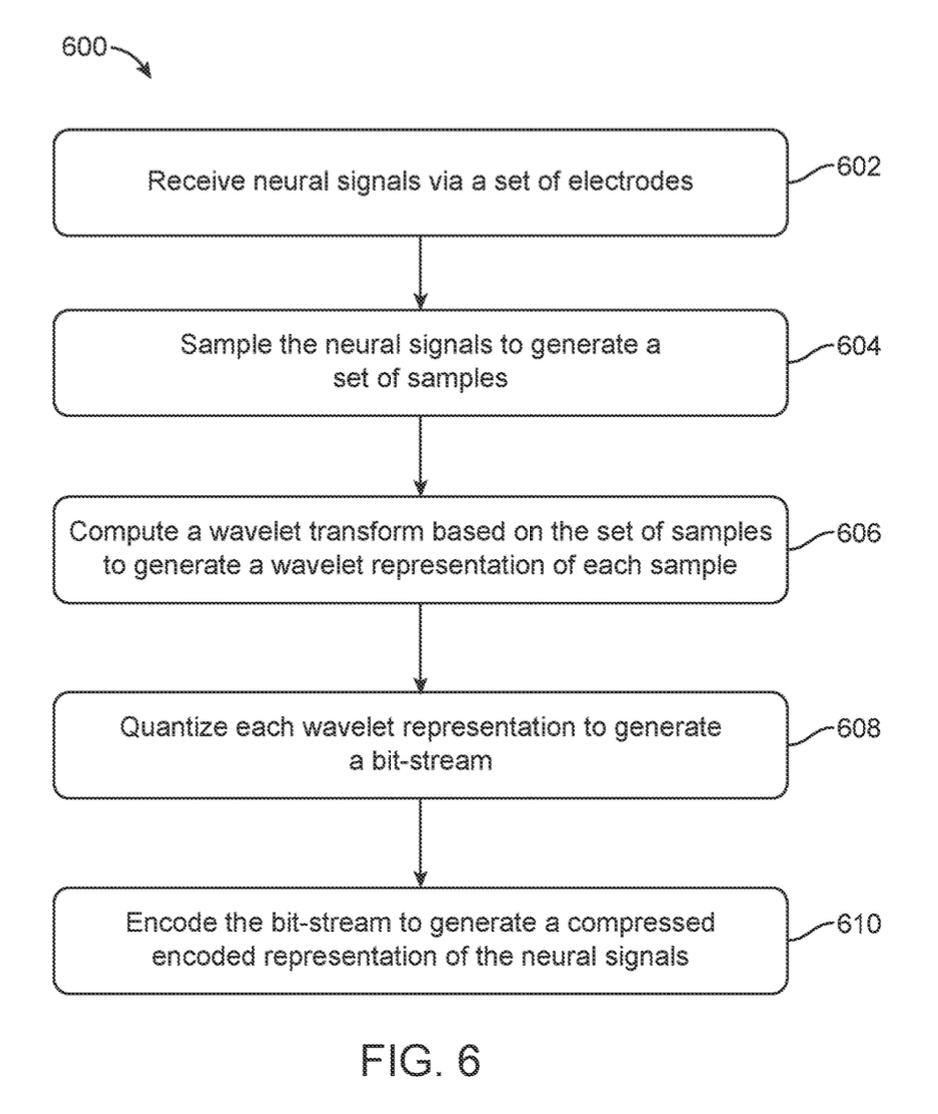

### 1. Receive Signal

Receive neural signals from electrodes. 

### 2. Generate Set of Samples (that correspond to spikes)

Detect spikes in the signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

Let's **reuse the results from the first two steps** from the last part (Lossless Compression Algorithm), since they are **identical**. 

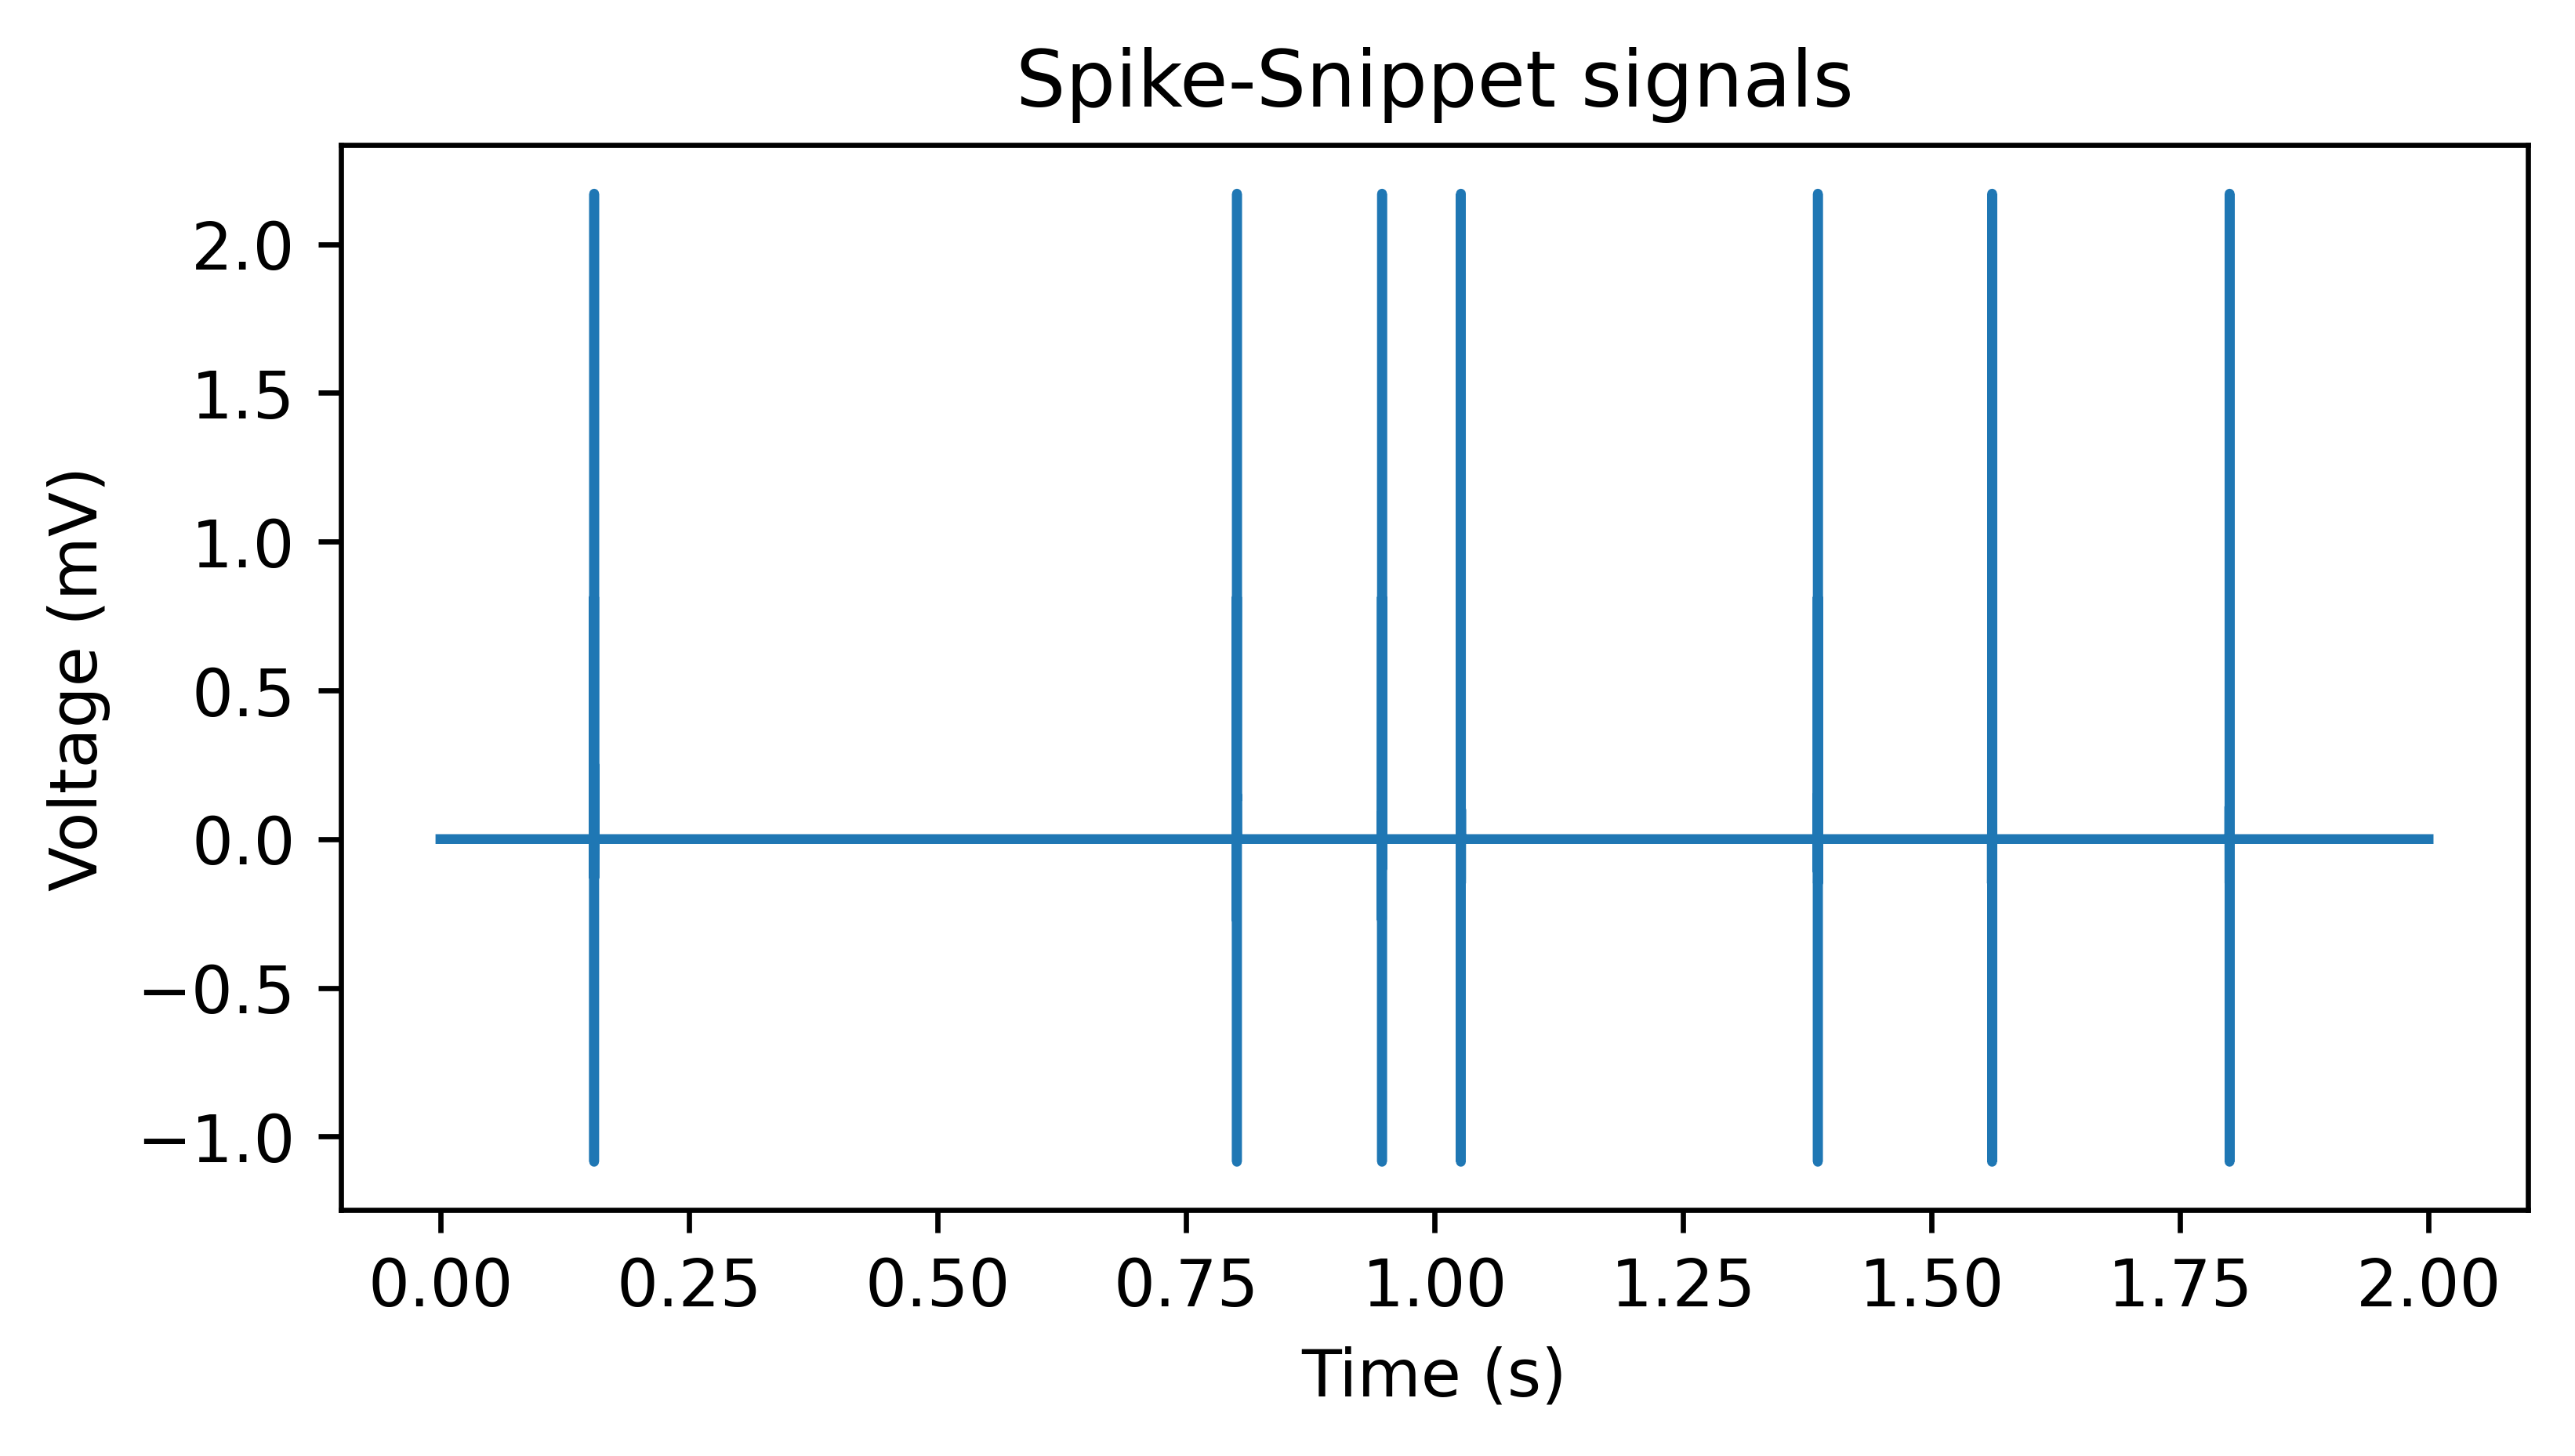

In [978]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

Now choose a subset of the snippets that are non-zero (only focus on the spikes). 

In [1026]:
# Choose non-zero x_snippets
x_snippets_nonzero = x_snippets[x_snippets != 0]

### 3. Determine Wavelet Transform

Determine the wavelet representations for each sample by performing a **wavelet transform** w.r.t. the set of samples, such as a **discrete wavelet transform (DWT)**, which decomposes the signal into a number of sets of time series of coefficients describing the time evolution in corresponding frequency band.  

Can use a **[Biorthogonal 2.2 wavelet (Bior 2.2)](https://wavelets.pybytes.com/wavelet/bior2.2/)**. 

In [1027]:
def wavelet_representation(signal, wavelet = 'bior2.2'):
    # Define the wavelet family and level of decomposition
    level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    
    # Perform the discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    return coeffs

# Example usage
coeffs = wavelet_representation(x_snippets_nonzero)

### 4. Quantize Wavelets to Bitstream

Quantizing the wavelets **restricts each wavelet representation** into **discrete (unary/binary) values**, using techniques such as **[probability mass function (PMF) quantization](https://ocw.mit.edu/courses/6-450-principles-of-digital-communications-i-fall-2006/926689aaa62a0315473fa9b982de1b07_book_3.pdf)**.

We effectively **reduce the amount of bits or computational resources per detail**, with the **most important information** stored in **lower frequencies** (with higher frequency close to little or no information). 

In [1029]:
def compute_pmf(coefficients):
    pmf = []
    for coeff in coefficients:
        hist, bins = np.histogram(coeff, bins=6, density=True)
        pmf.append(hist)
    return pmf

def quantize_wavelets(coeffs, pmf):
    quantized_coeffs = []
    for i, coeff in enumerate(coeffs):
        levels = len(pmf[i])
        quantized = np.zeros_like(coeff)
        for j in range(levels):
            idx = np.abs(coeff - pmf[i][j]).argmin()
            quantized[idx] = j
        quantized_coeffs.append(quantized)
    return quantized_coeffs

# Example usage
pmf = compute_pmf(coeffs)
quantized_coeffs = quantize_wavelets(coeffs, pmf)

### 5. Encode Bitstream

Append the **details** from the wavelet representation into the bit stream.

Use **[range Asymmetric Numerical Systems (rANS)](https://kedartatwawadi.github.io/post--ANS/)** to encode bit stream. 

An application of rANS, such as **fast rANS (frANS)**, may be used to **relax some constraints (e.g., PMF quantization)**, causing a **marginal loss of data ("lossy")**, while keeping the **accuracy loss negligible**.  

Note that since rANS is an **entropy-coding method**, it relies on **accurately classifying spikes in each bin based on spike categories**, as it **increases compression ratio** from 8:1 to 23:1. 

In [1030]:
def flatten_coeffs(quantized_coeffs):
    flattened_coeffs = np.concatenate([coeff.flatten() for coeff in quantized_coeffs])
    return flattened_coeffs

def rANS_encode(coeffs):
    # Convert to list of integers
    integers = [int(x) for x in coeffs]
    
    # Convert integers to bytes
    byte_array = array.array('B', integers).tobytes()
    
    # Compress the byte array using rANS
    compressed = rANS_compress(byte_array)
    
    return compressed

def rANS_compress(data):
    # Perform rANS compression
    freqs = {}
    for byte in data:
        if byte not in freqs:
            freqs[byte] = 0
        freqs[byte] += 1
    
    state = 0
    scale = 0x10000
    mask = 0xFFFF
    compressed = bytearray()
    
    for byte in data:
        freq = freqs[byte]
        state = (state // freq) << 16 | (state % freq) + freq * (state >> 16)
        while state >= scale:
            compressed.append(state & mask)
            state >>= 16
    
    compressed.extend(state.to_bytes(4, 'little'))
    
    return compressed

def frANS_relax_constraints(coeffs):
    # Relax constraints using frANS
    relaxed_coeffs = []
    for coeff in coeffs:
        if isinstance(coeff, np.ndarray):
            relaxed_coeffs.append(coeff)
        else:
            relaxed_coeffs.append(fractions.Fraction(coeff).limit_denominator())
    return relaxed_coeffs

# Example usage
flattened_coeffs = flatten_coeffs(quantized_coeffs)
compressed_coeffs = rANS_encode(flattened_coeffs)
relaxed_coeffs = frANS_relax_constraints(coeffs)

In [1073]:
# Flatten the relaxed coeffs
relaxed_coeffs_flattened = []
for arr in relaxed_coeffs:
    for val in arr:
        relaxed_coeffs_flattened.append(val)

### Encoded Bitstream:

In [1074]:
def float_to_bits(f):
    # Convert floating-point number to its IEEE 754 binary representation
    return ''.join(f'{c}' for c in np.unpackbits(np.array([f], dtype=np.float32).view(np.uint8)))

In [1075]:
bitstream = ''
for array in relaxed_coeffs:
    for num in array:
        bitstream += float_to_bits(num)
bitstream

'001000010000110100000111101111110010111001001010001010111011110111010111001001110001101000111111110011111011100001100001101111100001000101000000101001110011111100010110100011011101101100111110001111001001101000011110001111111011000011100000000111000011111100100000101101100101100100111110000101011110110100110000001111111011110011100011010000010011111110100011010110100111001010111110100011101100010010010001001110111011100011011111001111111011111010001111010011011110111100111110100001111111100100111011101111110001001000011010011110101011111010001100100110100100100100111111011010000100110001111111101111101010110100101111111111110011110110000111100011101110101110111110011001110000111000101100001111000000011101001100111010110011111000110101101010001111011100111110001000100100111010101011101111010110101111101110001010101011111110101011111101101001100100111101011101100010100111001101001111010001100010101011111111010011111000101001010000101101110110111101010010101100111100101000001111100000011

### Additional: Decode Bitstream

In [1076]:
def bits_to_float(bitstring):
    # Convert IEEE 754 binary representation to a floating-point number
    bits = [int(b) for b in bitstring]
    bytes_array = np.packbits(bits)
    return np.frombuffer(bytes_array, dtype=np.float32)[0]

def decode_bitstream(bitstream):
    floats = []
    float_bits_len = 32  # Assuming 32-bit float representation
    for i in range(0, len(bitstream), float_bits_len):
        float_bits = bitstream[i:i+float_bits_len]
        floats.append(bits_to_float(float_bits))
    return floats

In [1093]:
decoded_coeffs = decode_bitstream(bitstream)

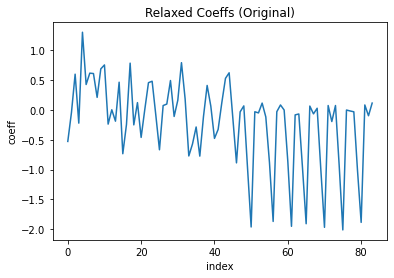

In [1078]:
# Plot the original computed relaxed coeffs:
plt.title("Relaxed Coeffs (Original)")
plt.ylabel('coeff')
plt.xlabel('index')
plt.plot(relaxed_coeffs_flattened)
plt.show()

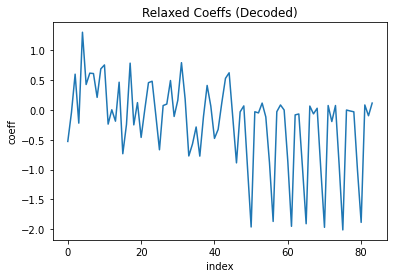

In [1079]:
# Plot the decoded relaxed coeffs:
plt.title("Relaxed Coeffs (Decoded)")
plt.ylabel('coeff')
plt.xlabel('index')
plt.plot(decoded_coeffs)
plt.show()

We can see that the computed indices are identical between the decoded and the relaxed coeffs, which means that our implementation has sucessfully encoded/decoded the relaxed coefficients. 

## <font color='green'> Sparse Compression: Binned-Spikes </font> 

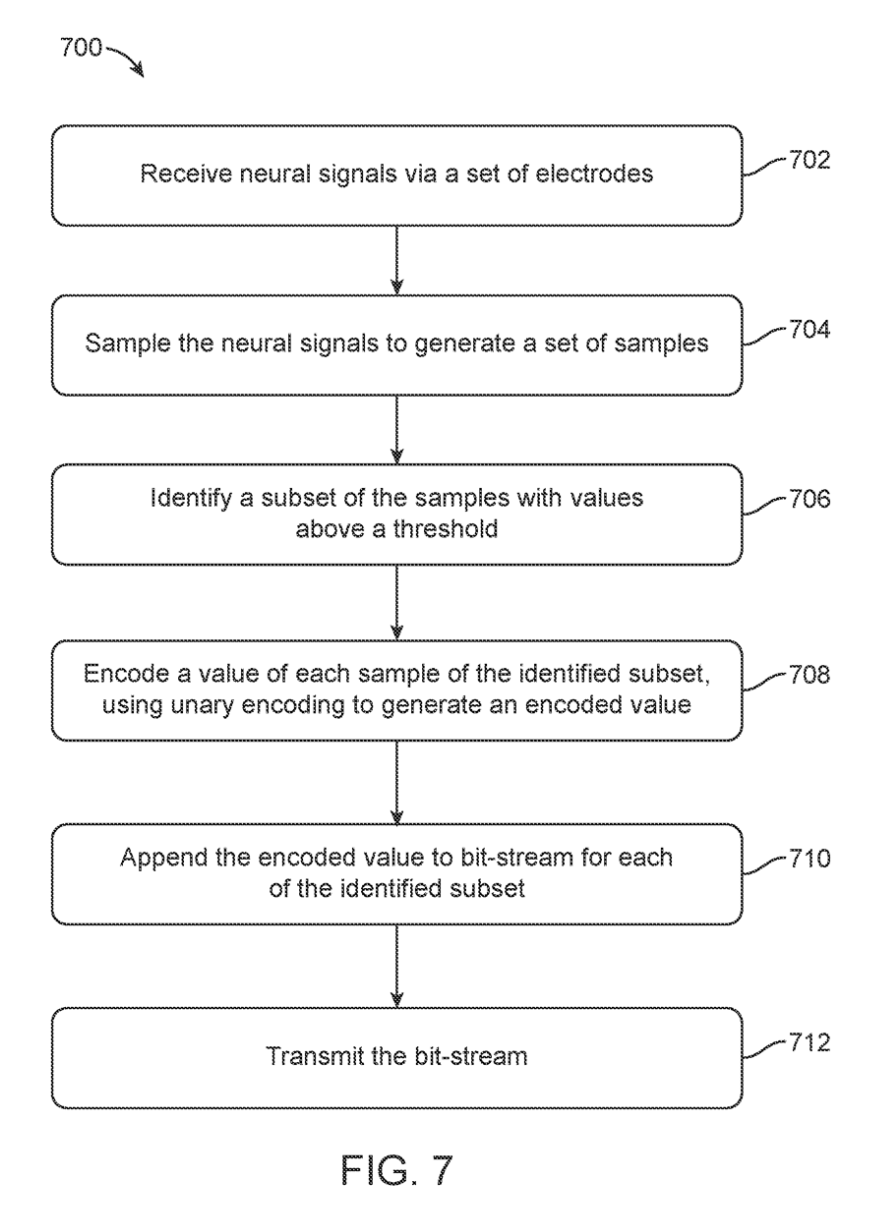

### 1. Receive Signal

Receive neural signals from electrodes. 

### 2. Generate Set of Samples (that correspond to spikes)

Detect spikes in the signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

Let's **reuse the results from the first two steps** from the last part (Lossless Compression Algorithm), since they are **identical**. 

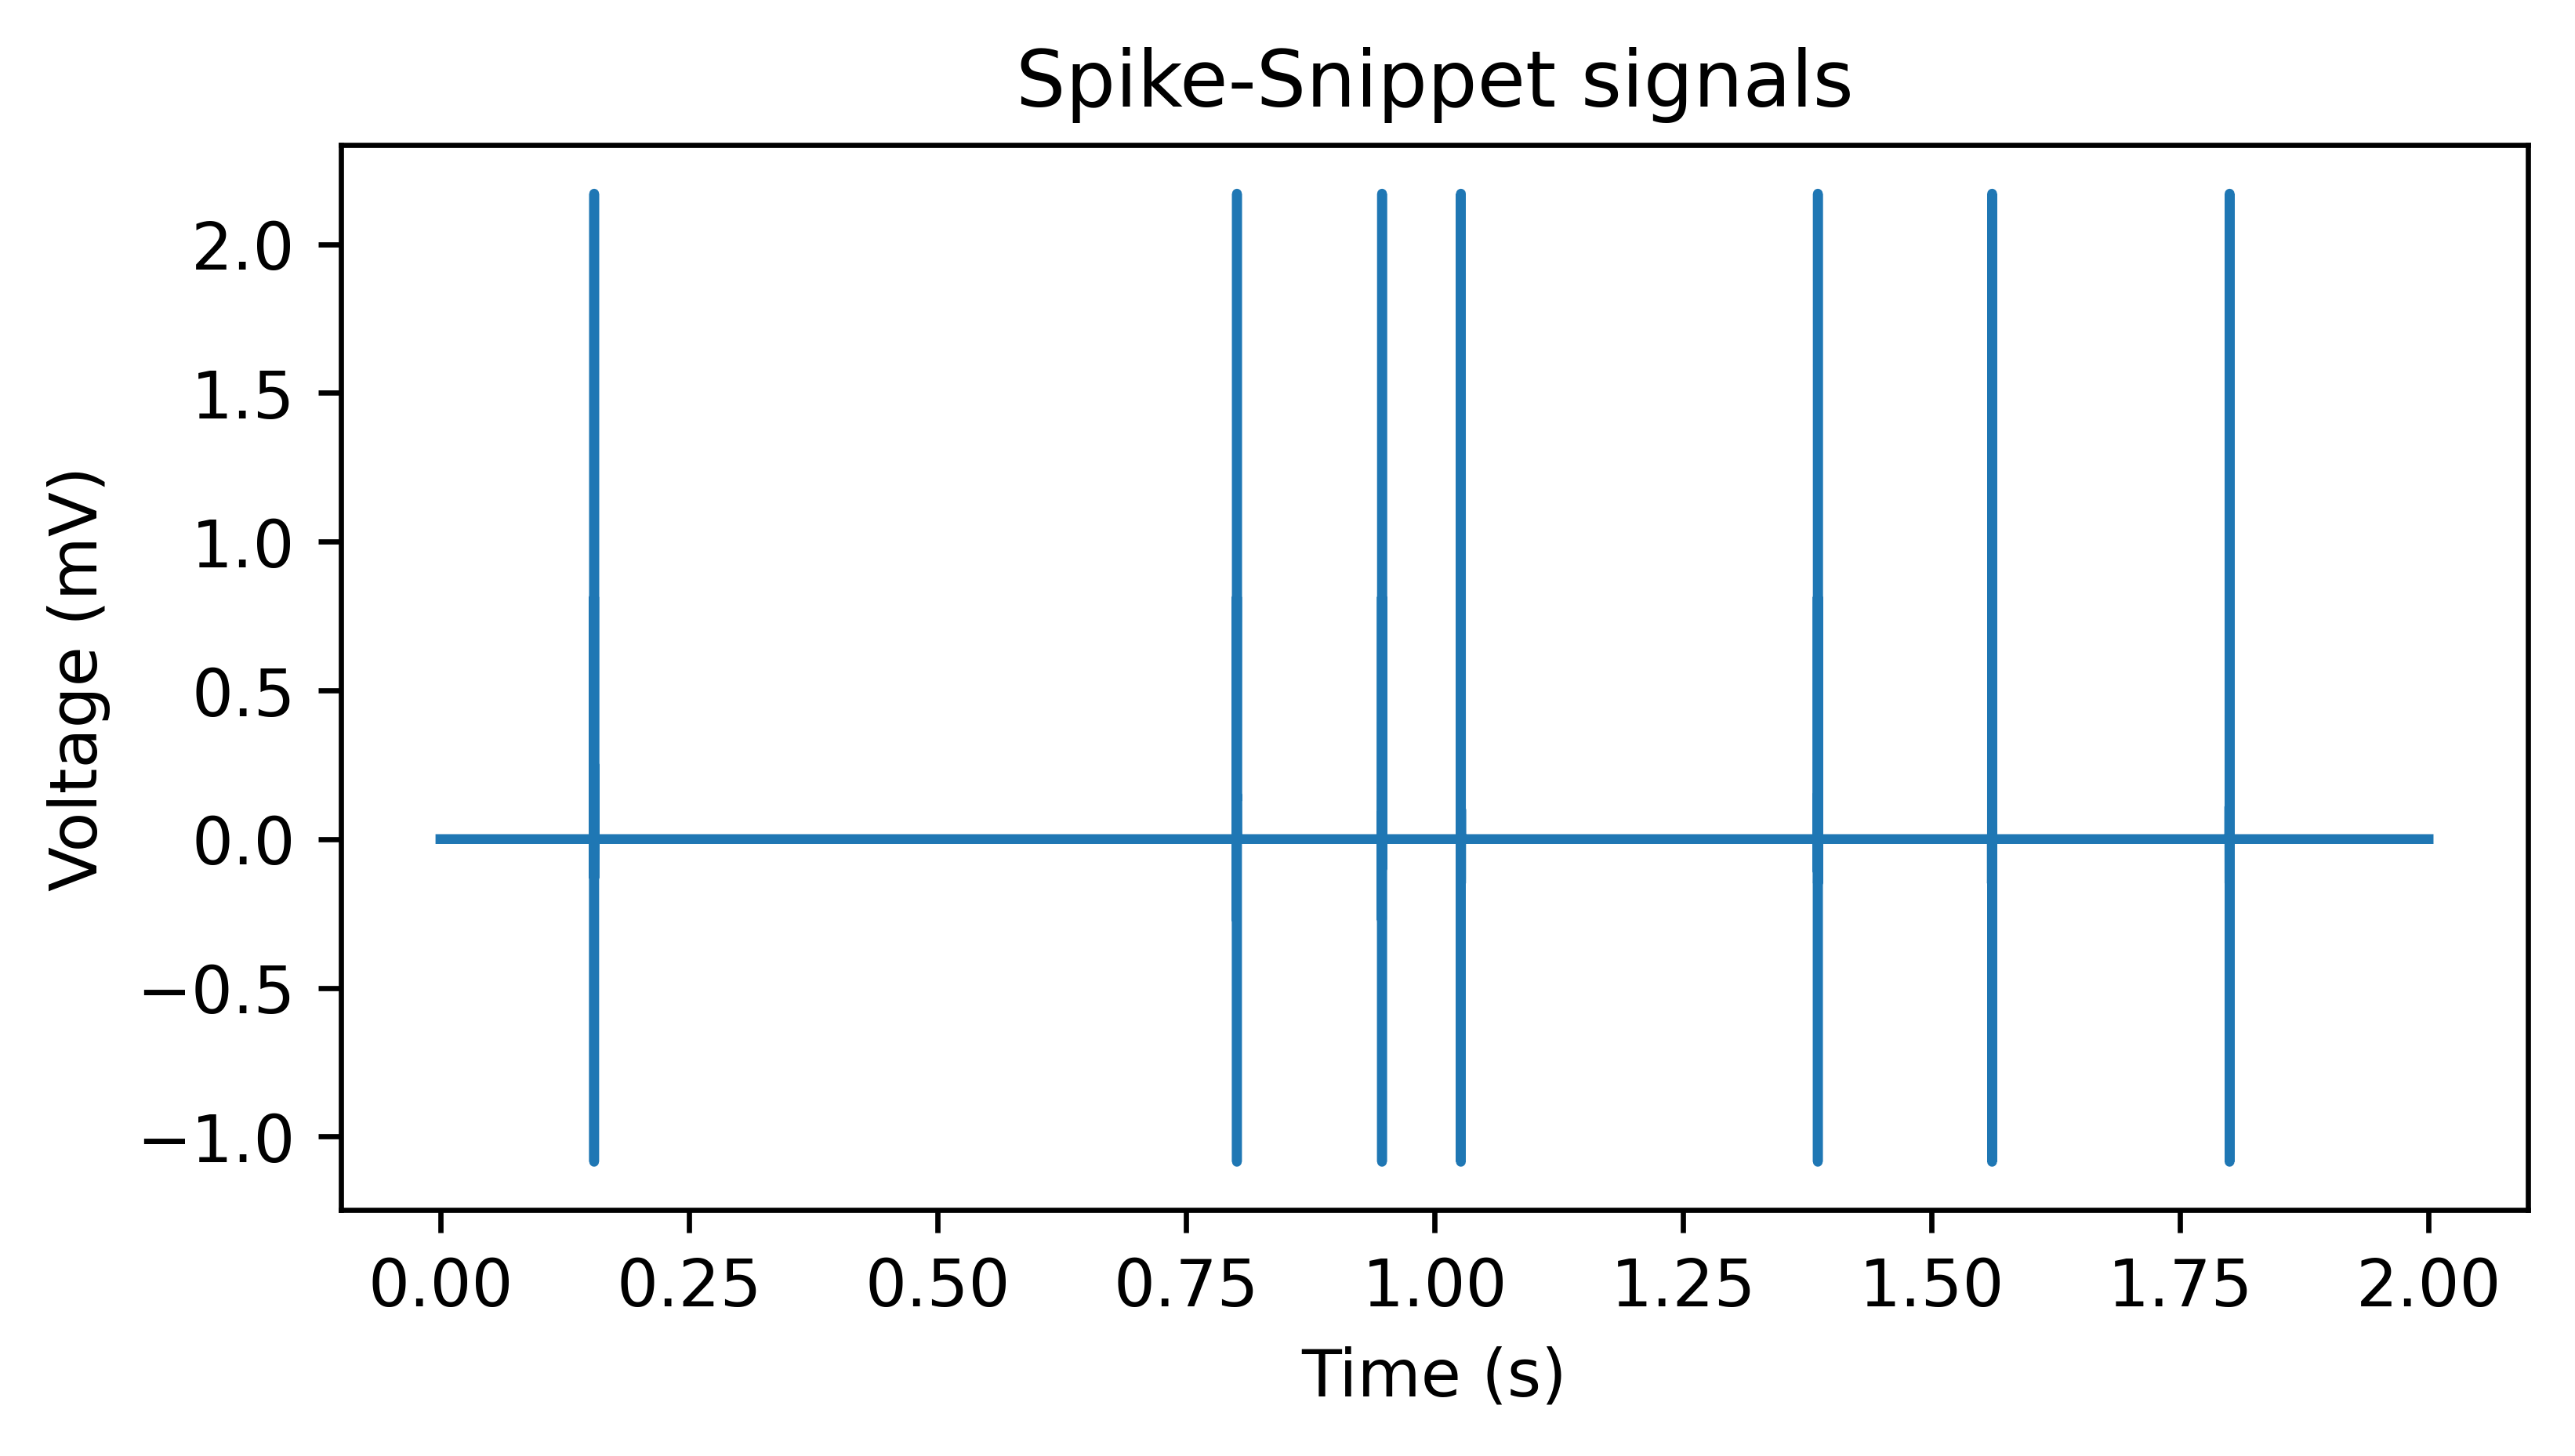

In [936]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

### 3. Identify non-zero subset of samples 

Filter out all values that equal to zero to leverage the sparse nature of neural signals. **DO NOT transmit if all signals are zero.**

In [937]:
nonzero_indices = np.where(np.abs(x_snippets) > 0)[0]
x_nonzero = np.abs(x_snippets[nonzero_indices])
t_nonzero = t[nonzero_indices]

In [938]:
# Transmit the signal only when there are 1 or more non-zero values
transmit = len(x_nonzero) != 0
transmit

True

### 4. Encode non-zero values via unary uncoding

Use the same procedure as described in "Lossless Compression", except that we are ignoring the remainder (binary encoding). 

In [939]:
def unary_encoding(value, m):
    abs_value = abs(value)
    quotient = abs_value // m # q = int(x / m)
    unary_code = '1' * quotient + '0' 
    return unary_code

In [940]:
values_q88 = (x_nonzero * (2**frac_bits)).astype(int)
unary = np.vectorize(unary_encoding)
encoded_values = unary(values_q88, m)

### 5. Append encoded values to bitstream

If all values are zero or close to zero -> append "0" to bit stream 

Otherwise, if 1 or more values are non-zero -> append "1" + each encoded value to bit stream

In [941]:
if transmit:
    # append "1" + each encoded value to bit stream
    bitstream = '1'
    
    for value in encoded_values:
        bitstream += value
else:
    # append "0" to bit stream
    bitstream = '0' 

### 6. Transmit Bitstream 

Transmit bitstream to external device.

**Note: Do NOT transmit bitstream if all samples are zero**

In [942]:
bitstream

'101110011111111111111111111111011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111011101101111111011011111101111111001111111011111101111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101110111101101111110111111100111111101111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101101110111011110011111111111111111111111011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111001111011101101111001110111111111111111111111110111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110111101110110111111101111011101101111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101111111001111111011111101110011110111111111111111111111110111111111111111111111111111111011111111111111111111111111111111111111111111

### Additional: Decode bitstream

External device decodes bitstream for further analysis

Reverse all or some steps from above process - **reconstruct samples**

In [943]:
def unary_decoding(encoded_value, m):
    quotient = encoded_value.index('0')
    abs_value = quotient * m
    return abs_value

In [944]:
decoded_values = []

if transmit:
    index = 1 # ignore the 'transmit' bit ('1')
    while index < len(bitstream):
        substr_end = index + bitstream[index:].index('0') + 1
        decoded_value_q88 = unary_decoding(bitstream[index : substr_end], m)
        decoded_value = decoded_value_q88 / (2**frac_bits)
        decoded_values.append(decoded_value)
        index = substr_end

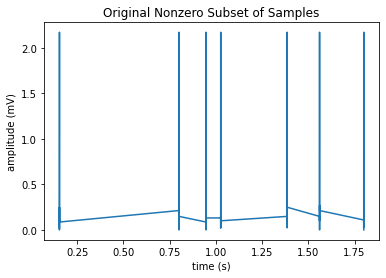

In [945]:
# Plot original nonzero subset of samples
plt.title("Original Nonzero Subset of Samples")
plt.plot(t[nonzero_indices], x_nonzero)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

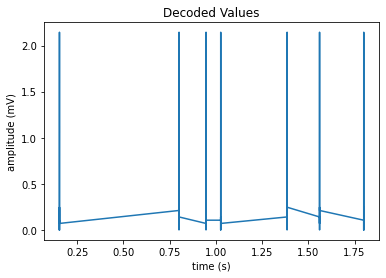

In [946]:
# Plot decoded values (from the Rice-Golomb encoded values)
plt.title("Decoded Values")
plt.plot(t[nonzero_indices], decoded_values)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

You can see here that the decoded values and the original subset of samples (ground truth) are very similar in plot shape, as their values scale similarly. That means our encoding/decoding works properly. 

## <font color='green'>Sparse Compression: Spike-Band</font>

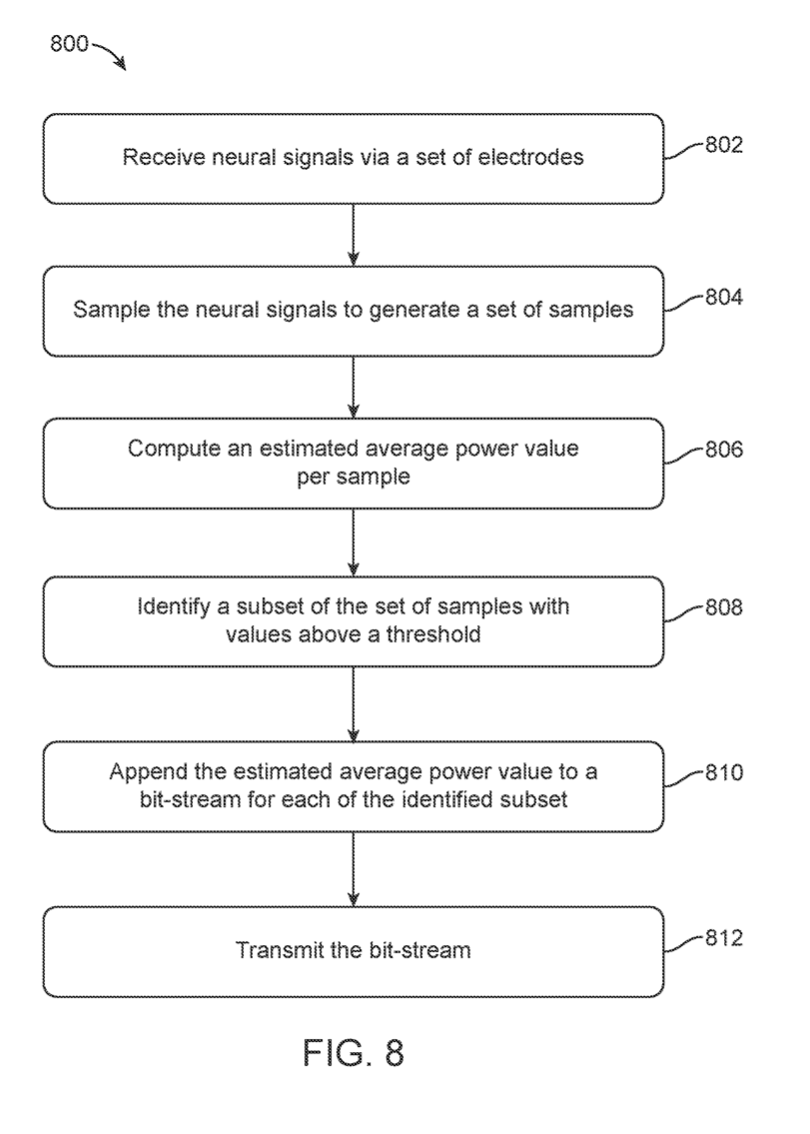

### 1. Receive Signal + Detect Spikes

Receive neural signals from electrodes, and only keep the signals corresponding to spikes. 

Then apply a filter to this signal. 

Refer to the [notebook](https://github.com/michaela10c/neural_spike_detection/) for US patent 2021/0012909 A1, "Real-Time Neural Spike Detection". 

Let's **reuse the results from the first two steps** from the last part (Lossless Compression Algorithm), since they are **identical**. 

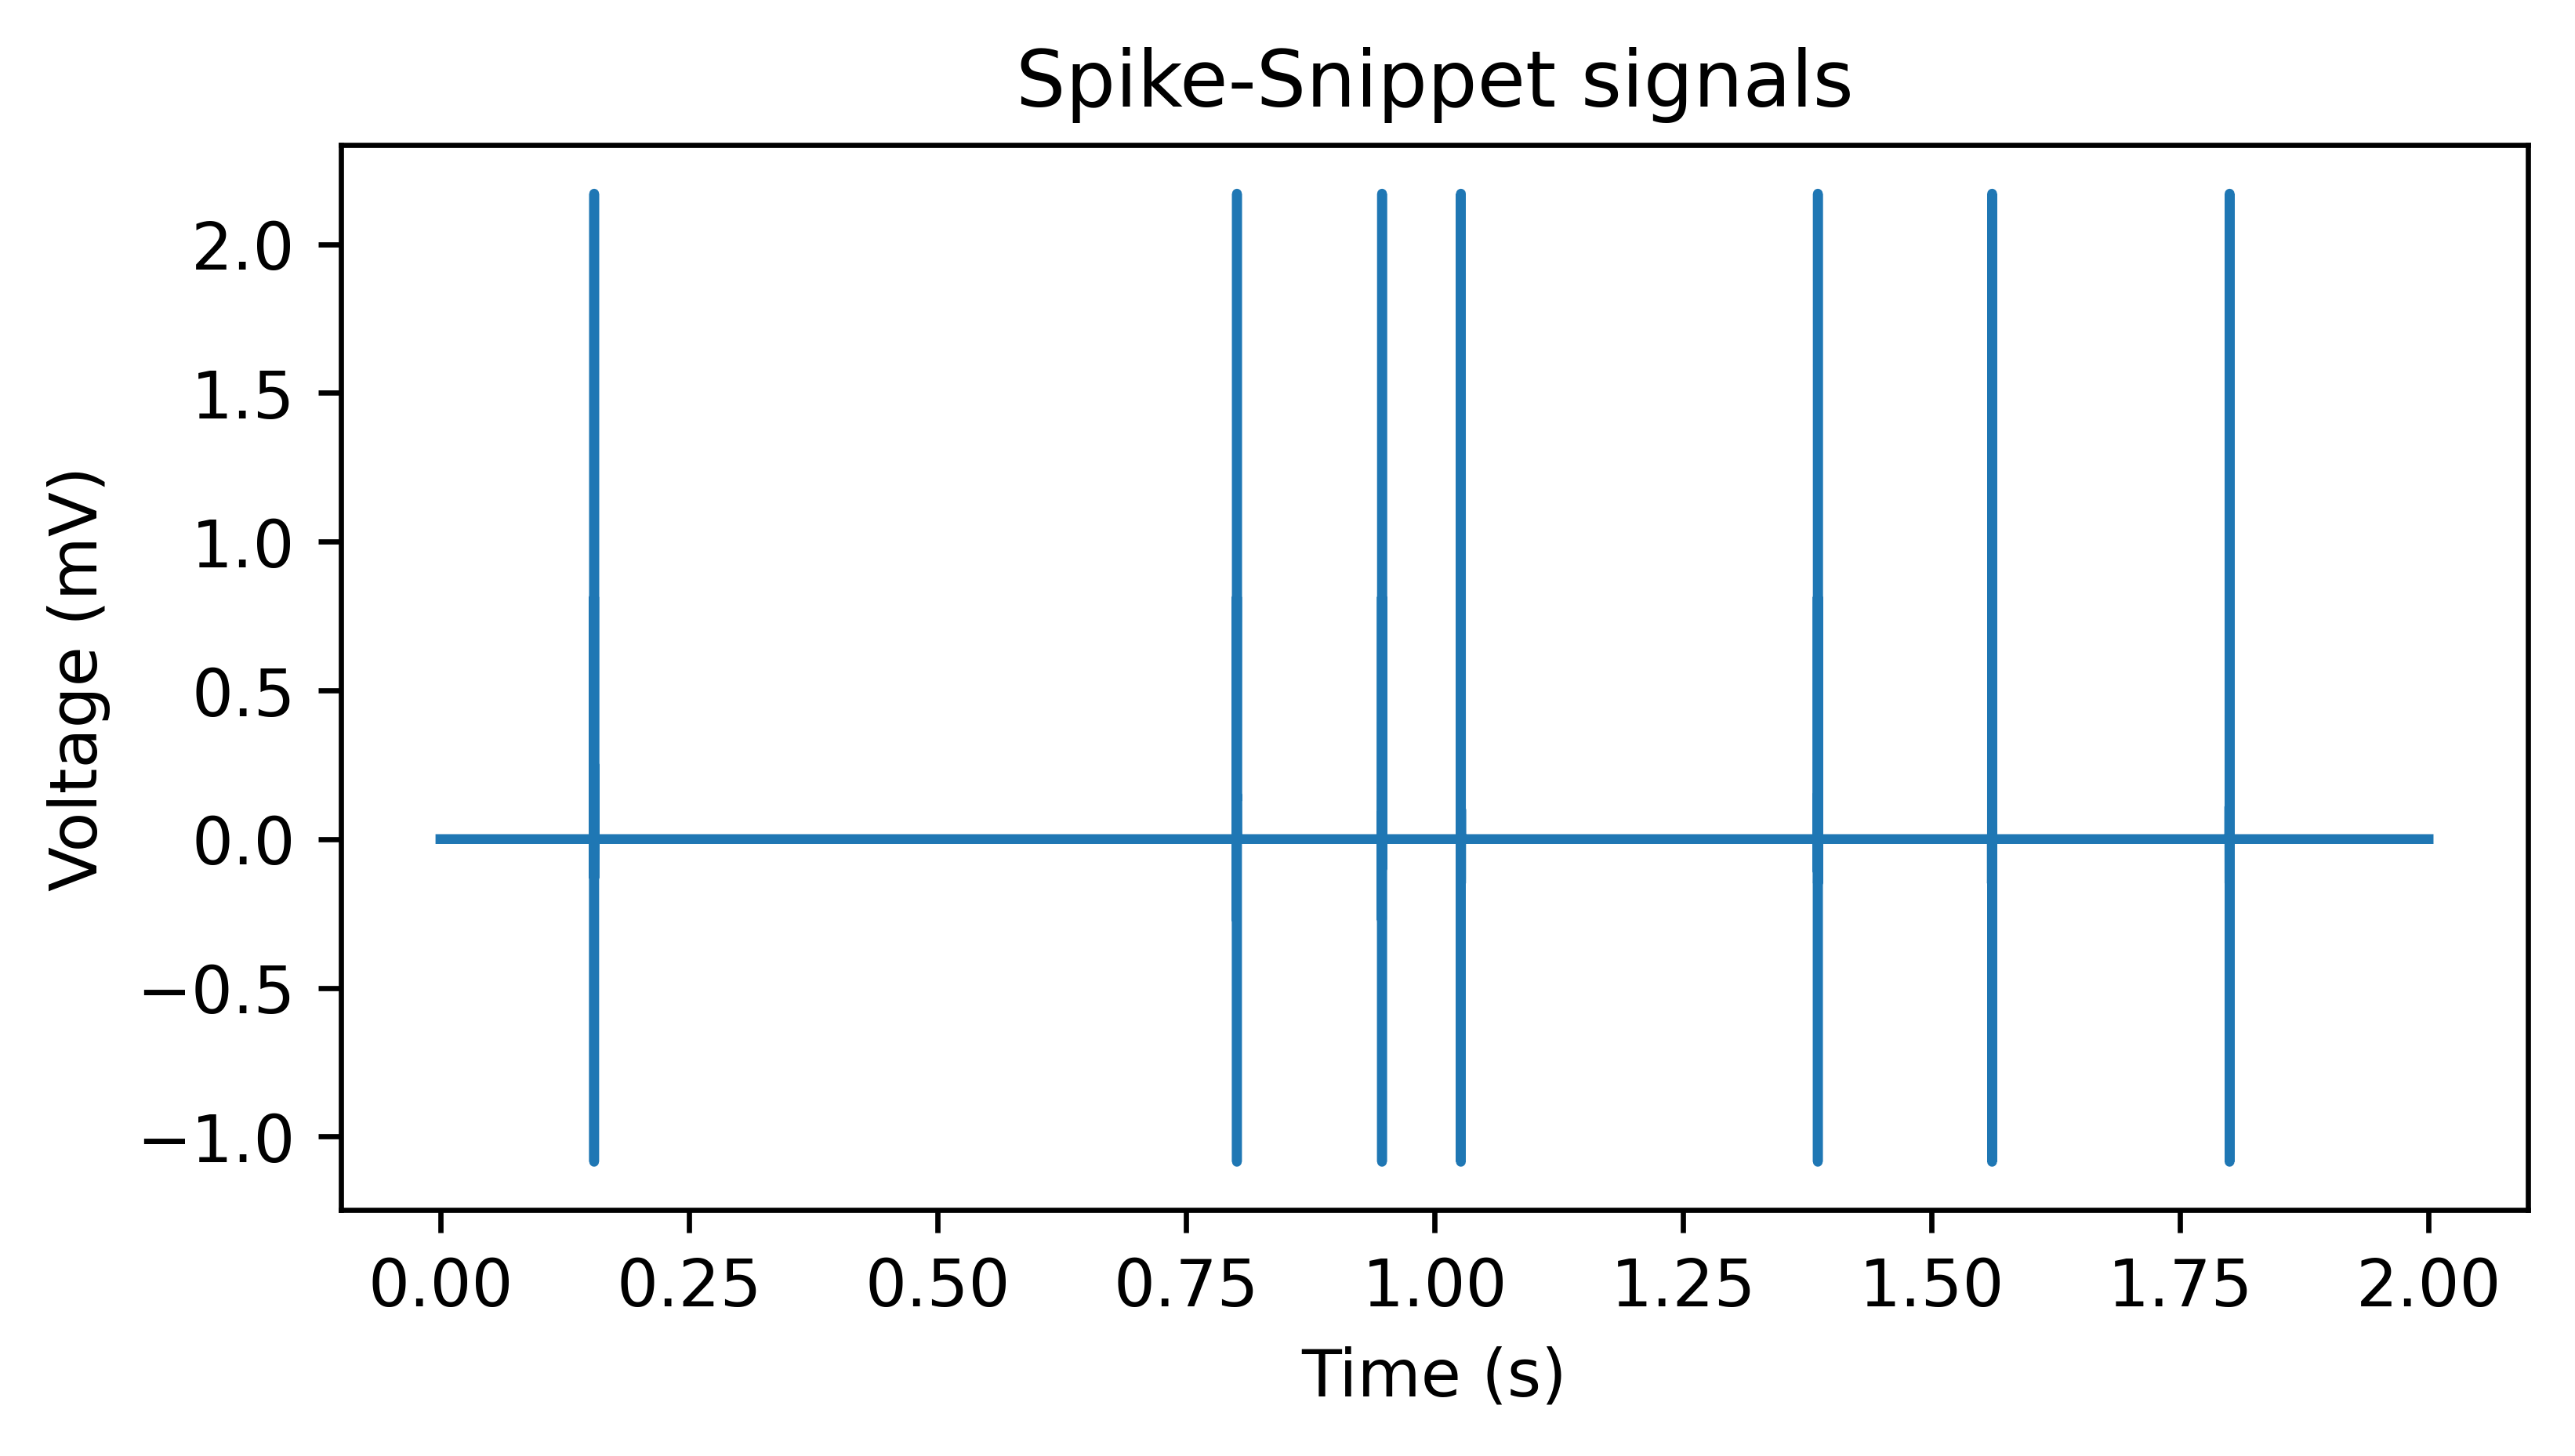

In [947]:
# Plot the spike-snippet signals
fig, ax = plt.subplots(1, 1, figsize=(6, 3),dpi = 600)

plt.title("Spike-Snippet signals")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (s)")

plt.plot(t, x_snippets)
plt.show()

In [948]:
# Apply a filter to the spike-snippets signal
filtered_signal = spike_detector.filter_signal(x_snippets)

### 2. Generate Set of Samples

Compute an absolute value of each sampled channel. Each sample represents a channel. 

In [962]:
filtered_signal = np.abs(filtered_signal)

### 3. Calculate average power (i.e., average amplitude)

Compute average power for each fixed time window.

In [963]:
def average_val(signal, i1, i2):
    return np.mean(signal[i1 : i2])

In [964]:
def average_power(signal, blackout_period=0.01):
    index = 0
    duration = time_to_index(blackout_period)
    mean = []
    
    while index < len(signal) - duration:
        avg = average_val(signal, index, index + duration)
        mean.append(avg)
        index += 1
        
    return np.array(mean)

In [965]:
avg_power = average_power(filtered_signal, blackout_period=0.01) # use a 10ms time window

### 4. Identify subset with nonzero average power

Identify subset of samples with nonzero average power

In [966]:
# Identify subset with non-zero average power
nonzero_indices = np.where(avg_power > 1e-8)[0]
avg_power_nonzero = avg_power[nonzero_indices]

In [967]:
# Transmit the signal only when there are 1 or more non-zero values
transmit = len(avg_power_nonzero) != 0
transmit

True

### 5. Append encoded values to bitstream

Encode to unary as following: 
- If average power value is nonzero, append "1" + average values to bitstream 
- If average power value is zero, append "0" to bitstream

In [968]:
# Find the maximum value in the data
max_value_q88 = max(abs(int(value * (2**frac_bits))) for value in avg_power_nonzero)

# Determine the optimal value for 'm'
m = determine_optimal_m(max_value_q88)

print("optimal 'm':", m)

optimal 'm': 3


In [969]:
values_q88 = (avg_power_nonzero * (2**frac_bits)).astype(int)
encoded_values = unary(values_q88, m)

In [970]:
if transmit:
    # append "1" + each encoded value to bit stream
    bitstream = '1'
    
    for value in encoded_values:
        bitstream += value
else:
    # append "0" to bit stream
    bitstream = '0' 

### 6. Transmit Bitstream 

Transmit bitstream to external device.

**Note: Do NOT transmit bitstream if all samples are zero**

In [971]:
bitstream

'100000001010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101000000000000000000000000000000000000000000000000000000000000000000000000000000101010101010101010101010101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101101

### Additional: Decode bitstream

External device decodes bitstream for further analysis

Reverse all or some steps from above process - **reconstruct average power vector**

In [972]:
decoded_values = []

if transmit:
    index = 1 # ignore the 'transmit' bit ('1')
    while index < len(bitstream):
        substr_end = index + bitstream[index:].index('0') + 1
        decoded_value_q88 = unary_decoding(bitstream[index : substr_end], m)
        decoded_value = decoded_value_q88 / (2**frac_bits)
        decoded_values.append(decoded_value)
        index = substr_end

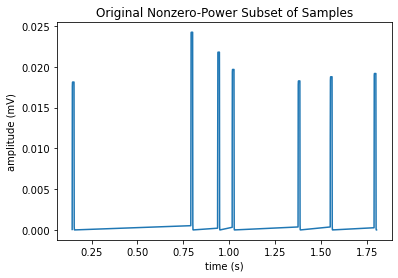

In [973]:
# Plot original nonzero subset of samples
plt.title("Original Nonzero-Power Subset of Samples")
plt.plot(t[nonzero_indices], avg_power_nonzero)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

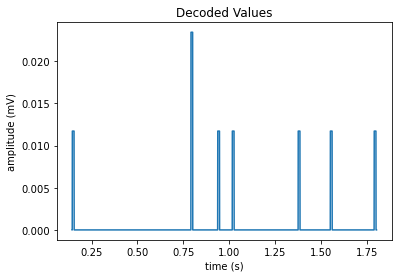

In [974]:
# Plot decoded values (from the Rice-Golomb encoded values)
plt.title("Decoded Values")
plt.plot(t[nonzero_indices], decoded_values)
plt.xlabel('time (s)')
plt.ylabel('amplitude (mV)')
plt.show()

We can see that there are **different amplitude magnitudes** between the two signals, which can be attributed to the **unary encoding scheme**, where we take the *quotient* of each encoded value, rather than the value itself. 

Yet despite different values and scaling, we can see that the two plots (original nonzero power subset & decoded values) are similar in that **spikes are visible in both plots**, since spike-band mode **only cares about** signals that are **spikes**. 

This shows that our encoding/decoding method works well enough for our application.  